# Modeling with k-means, Part 2

In this notebook I apply the methods of Part1 to the California housing dataset.  See my CA_housing_analysis repository for an introduction to this dataset.  In that analysis, the response variable was the median house value of 1990 Census districts in the state of California.  Here I use the dataset for a classification model that distinguishes between the INLAND districts and the non-INLAND districts (i.e., those districts closer to the ocean).  As with the downer cow dataset, I want to see whether we can construct a better classification model using k-means in combination with one or more supervised learning algorithms. 

Prior work suggests that a k-means hybrid model will likely not be able to out-perform competing models which are already excellent classifiers.  The greater the accuracy score of a competing model, the less room there is for improvement upon that score.  One reason the hybrid model of Part 1 did well is due to the fact that k-means, as an unsupervised algorithm, was already very good at distinguishing between the surviving cows and the non-survivors.  (In other words, k-means was already very competitive with the other models prior to using it in a hybrid model.)  This meant that when we combined it with another model of the right sort, we were able to obtain a hybrid model which outperformed the competing models.  This will not happen unless the models being combined contribute different, yet complementary, information.  For example, the support vector classifier of Part 1 did not mix well with k-means, although the logistic regression model did.  If I had tried to further boost the hybrid model by adding a second probability column generated from the gradient boosting model, we would have seen no further gain because the gradient boosting model does not have any further, or new, information to contribute.

One lesson from Part 1, then, is that a hybrid k-means model is more likely to outperform competing models when the competing models do not have great accuracy scores.  The competing models in Part 1 had accuracy scores around 70%.  It also helps quite a bit if the k-means algorithm itself, in an unsupervised setting, does a very good job of partitioning the data into the desired classes.

In prior work with the CA housing data (version 4 of this notebook), the best classifier was a random forest model with an accuracy score just under 90%.  This model relied on 7 of the predictors, excluding latitude and longitude.  (If we include latitude and longitude, it is far too easy to distinguish inland districts from those much closer to the ocean.)  The k-means algorithm, unsupervised, does a very poor job distinguishing between the 2 classes.  This meant that adding a prob01 column to the dataset that k-means worked with---the prob01 column containing probability scores from another classifier using supervised learning---was not enough to yield a hybrid model which was better than the all of the other models.  The hybrid model was only second-best.  If one adds a second probability column (generated from a model different from the one used for the prob01 column, of course), the hybrid model scores increase slightly, but not enough to beat the random forest model.

In version 4 of this notebook weights were of little help, likely because of the number of predictors being used in the model, but perhaps also because of the amount of data.  I suspect that the more predictors, or dimensions, k-means has to work with (assuming all are meaningful predictors), the less benefit we will see from optimal weights.  Furthermore, the more predictors we have and the more data, the harder it becomes to find optimal weights; the parameter space we have to search through becomes too large for a thorough search.

Thus in this notebook I will limit the number of predictors I work with so that competing classifiers have accuracy scores at or below 75%.  This increases the likelihood of a hybrid model being able to out-perform the competing models.  If I end up with only 3 predictors, I can again see if weights can improve the k-means model.  The weights will be difficult to find, though, since the CA housing dataset is so much larger than the cow dataset. 




                                        * * * * * 

# Preliminaries

In [ ]:
require(car)
require(repr)
require(ggplot2)
require(stringr)
require(parallel)
require(faraway)
require(randomForest)
require(gbm)
require(plyr)
require(e1071)


In [2]:
options(digits= 5, show.signif.stars= FALSE)


## Construct training and test sets

In [3]:
traindat <- read.csv("/home/greg/Documents/stat/Geron_ML/datasets/housing/train_revised_27JUN2021.csv",
                     header=TRUE, row.names=1,
                     colClasses= c("character", rep("numeric", 9), "character",
                                   rep("numeric", 5), "character"))
dim(traindat)


[1] 16482    16

In [4]:
colnames(traindat)


[1] "longitude"          "latitude"           "housing_median_age"
 [4] "total_rooms"        "total_bedrooms"     "population"        
 [7] "households"         "median_income"      "median_house_value"
[10] "ocean_proximity"    "rooms_per_hh"       "bdrms_per_room"    
[13] "pop_per_hh"         "HHdens_ln"          "long_transf"       
[16] "income_cat"

In [7]:
table(as.factor(traindat$ocean_proximity))



    INLAND   NEAR BAY NEAR OCEAN      OCEAN 
      5187       1820       2137       7338 

In [5]:
testdat <- read.csv("/home/greg/Documents/stat/Geron_ML/datasets/housing/test_revised_27JUN2021.csv",
                    header=TRUE, row.names=1,
                    colClasses= c("character", rep("numeric", 9), "character",
                                  rep("numeric", 5), "character"))
dim(testdat)


[1] 4121   16

In [8]:
dat <- rbind(traindat, testdat)
dat$Inland <- 0
dat[which(dat$ocean_proximity== "INLAND"),]$Inland <- 1
table(dat$Inland)



    0     1 
14078  6525 

In [10]:
# Remove predictors that are collinear, that we do not need, or
# that would be too helpful when identifying Inland districts.

newcols <- colnames(dat)[which(!(colnames(dat) %in% c("HHdensity", "income_cat",
                                                      "ocean_proximity", "longitude",
                                                      "latitude","long_transf",
                                                      "median_income","population",
                                                      "total_bedrooms","total_rooms",
                                                      "pop_per_hh","bdrms_per_room",
                                                      "HHdens_ln")))]
newcols


[1] "housing_median_age" "households"         "median_house_value"
[4] "rooms_per_hh"       "Inland"

In [11]:
dat <- dat[, newcols]
dim(dat)
colnames(dat)


[1] 20603     5

[1] "housing_median_age" "households"         "median_house_value"
[4] "rooms_per_hh"       "Inland"

In [12]:
# Create training and test sets for use in testing
# new k-means approach. 

set.seed(8763)
smp <- sample(rownames(dat), 10603, replace=FALSE)
traindat <- dat[smp,]
testdat <- dat[which(!(rownames(dat) %in% smp)),]
dim(testdat)


[1] 10000     5

In [13]:
rm(dat)


In [14]:
# Move the response variable, Inland, to the first
# column.

newcols <- colnames(traindat)
newcols <- newcols[which(!(newcols %in% c("Inland")))]
newcols <- c("Inland", newcols)
newcols


[1] "Inland"             "housing_median_age" "households"        
[4] "median_house_value" "rooms_per_hh"

In [15]:
traindat <- traindat[, newcols]
testdat <- testdat[, newcols]


In [16]:
# Save out the files.

write.csv(traindat, file="/home/greg/Documents/stat/github_repos/cows/CAhousing_train_10603.csv",
          row.names= TRUE)

write.csv(testdat, file="/home/greg/Documents/stat/github_repos/cows/CAhousing_test_10K.csv",
          row.names= TRUE)


In [43]:
traindat <- read.csv("/home/greg/Documents/stat/github_repos/cows/CAhousing_train_10603.csv",
                    header=TRUE, row.names=1, colClasses= c("character", rep("numeric",4)))
dim(traindat)


[1] 10603     5

In [44]:
testdat <- read.csv("/home/greg/Documents/stat/github_repos/cows/CAhousing_test_10K.csv",
                    header=TRUE, row.names=1, colClasses= c("character", rep("numeric",4)))
dim(testdat)


[1] 10000     5

In [17]:
# Get ratio of Inland to non-Inland in traindat.

round(mean(traindat$Inland), 4)


[1] 0.3105

In [18]:
# Get ratio of Inland to non-Inland in testdat.

round(mean(testdat$Inland), 4)


[1] 0.3233

## Basic functions

In [19]:
# Function for computing "proportion of deviance explained", an 
# R-sqrd statistic for link= logit.  See p.41 of Julian Faraway's
# "Extending the Linear Model with R" (2006: Chapman & Hall).  
# This statistic is due to N. Nagelkerke (1991; see Faraway's
# bibliography).

get_RsqrdDev <- function(modl) {
    
    n_obs <- length(modl$fitted.values)
    ans <- (1-exp((modl$deviance - modl$null.deviance)/n_obs))/(1-exp(-modl$null.deviance/n_obs))
    return(round(ans, 4))
}


In [20]:
# Function to compute f-score for a 2x2 confusion matrix.

get_fscore <- function(mat) {
    
    mat[is.na(mat)] <- 0
    FN <- as.numeric(mat[2,1])
    TP <- as.numeric(mat[2,2])
    FP <- as.numeric(mat[1,2])
    recall <- TP/(TP + FN)
    precision <- TP/(TP + FP)
    f_score <- 2* (recall*precision)/(recall + precision)
    return(round(f_score, 4))
}


In [21]:
# Function to output a confusion matrix and the f-score 
# for that matrix (if it is 2x2).

get_confusion <- function(preds, df_actual) {
    
    # df_actual is a one-column dataframe;
    # preds is a named vector of predictions;
    # preds is of type factor; it is assumed there are
    # at least 2 factor levels
    
    levs <- levels(preds)
    n_levs <- length(levs)
    if(n_levs== 1) { levs <- c('0', '1') }
    n_levs <- max(n_levs, 2)
    actual <- as.vector(df_actual[, 1])
    names(actual) <- rownames(df_actual)
    
    datout <- rep(0, n_levs * (n_levs + 1))
    dim(datout) <- c(n_levs, n_levs + 1)
    datout <- as.data.frame(datout)
    colnames(datout) <- c(levs, "class.error")
    rownames(datout) <- levs
    
    result <- vector("list", length= 2)
    names(result) <- c("matrix","f_score")
    
    # for each factor level, identify the rcd names
    # which should be classed as such
    for(rowlev in levs) {
        actlev_names <- names(actual[actual == rowlev])
        # columns are for the predicted values:
        for(collev in levs) {
            predlev_names <- names(preds[preds == collev])
            if(length(predlev_names > 0)) {
                datout[rowlev, collev] <- sum(predlev_names %in% actlev_names)
            }
        }
        nonrow_cols <- levs[!(levs %in% rowlev)]
        datout[rowlev, "class.error"] <- round(sum(as.vector(datout[rowlev, nonrow_cols]))/
                                               sum(as.vector(datout[rowlev, levs])), 4)
    }
    
    result$matrix <- datout
    if(n_levs == 2) {
        result[[2]] <- get_fscore(as.matrix(datout))
    } else {
        result$f_score <- NA
    }
    
    return(result)
}


In [22]:
# The following function is from Robert Kabacoff's "R in Action", pp.379-380.

wssplot <- function(data, title="", nc=15, seed=1233) {
    
    # wss[1] is the total sum of squares when there is only
    # one cluster.  In R's kmeans help this is called 'totss'.
    # Here is another way to compute totss: 
    # ss <- function(x) sum(scale(x, scale = FALSE)^2)
    wss <- (nrow(data) - 1)*sum(apply(data, 2, var))
    for(i in 2:nc) {
        set.seed(seed)
        km_model <- suppressWarnings(kmeans(data, centers=i, iter.max=50,
                                            nstart=5))
        wss[i] <- sum(km_model$withinss)
    }
    plot(1:nc, wss, type='b', xlab="Number of clusters",
        ylab="Within groups sum of squares",
        main= title)
}


In [23]:
# Function for identifying which cluster each record
# belongs to.  

getCluster <- function(x, centers) {
    
    # x is a row of a dataframe; its columns need
    # to be in the same order as centers (a matrix'
    # constructed from kmeans)
    
    cl_dist <- apply(centers, 1, function(y) sqrt(sum((x-y)^2)))
    return(which.min(cl_dist)[1])
}


In [24]:
# Function to generate combination of parameters for gridSearch;
# each combination must add to a number ~1.  Returns a dataframe, 
# each row of which is a valid combination.

# I re-factored this ftn using R's expand.grid ftn.  expand.grid
# takes more time to run, probably due to type-checking. 
# It appears that we also run out of memory more quickly when
# using expand.grid.  Thus, I avoid expand.grid in what follows.)

generate_combs <- function(arglist, tol=0.0001) {
    # arglist is a named list; each name is a column
    # name of the dataframe which goes to k-means
    
    #################################################
    # this next section is an alternative to expand.grid
    #################################################
    # if(FALSE) {
    n_args <- length(arglist)
  
    param_vlens <- rep(NA, n_args)
    for(i in 1:n_args) {
        param_vlens[i] <- length(arglist[[i]])
    }
    n_rows <- prod(param_vlens)
  
    datout <- rep(NA, n_args*n_rows)
    dim(datout) <- c(n_rows, n_args)
    datout <- as.data.frame(datout)
    colnames(datout) <- names(arglist)
  
    cprod <- 1
    for(j in 1:n_args) {
        vect <- arglist[[j]]
        val <- rep(vect, rep(cprod, length(vect)))
        datout[, j] <- rep(val, n_rows/length(val))
        cprod <- cprod*length(vect)
    }  
    # } ## end of 'if(FALSE)'
    #################################################
    
    # datout <- expand.grid(arglist, KEEP.OUT.ATTRS= FALSE)
    # colnames(datout) <- names(arglist)
    
    row_sums <- round(rowSums(datout), 4)
    names(row_sums) <- rownames(datout)
    tol <- tol
    row_sums <- row_sums[which((as.numeric(row_sums) <= (1 + tol)) & (as.numeric(row_sums) >= (1 - tol)))]
    datout <- datout[names(row_sums),]
    return(datout)
}


In [25]:
# Function to constrain range of data between 0 and 1.

range01 <- function(x) {(x - min(x))/(max(x) - min(x))}


In [26]:
# Function to constrain range of data between min_x and max_x.
# This function is used to transform validation data.

range02 <- function(x, min_x, max_x) {(x - min_x)/(max_x - min_x)}


In [165]:
# Function returning mapping between clusters and
# Inland levels.  We choose the mapping that yields
# the best f-score score.

c1_toLevel_1 <- function(dat) {
    
    # Returns TRUE if cluster 1 maps to Inland = 1
    
    # dat is a dataframe with 2 columns, c("Inland","cluster");
    # nrow(dat) = number of predictions from the model;
    # dat$Inland = traindat$Inland (from the calling function)
    
    # We find the correct mapping between cluster number and 
    # Inland level by computing f-scores for the different
    # valid mappings.   We choose the mapping with the best
    # f-score score.
    
    tbl <- as.matrix(table(dat$Inland, as.factor(dat$cluster)))
    # The colnames of tbl refer to the names of the clusters.
    
    # With only 2 levels for Inland, we need only 2 scores.
    scores <- rep(NA, 2)    
    
    # First possibility: cluster 1 maps to the non-Inland districts
    tmpdat <- dat
    tmpdat[which(tmpdat$cluster== 1),]$Inland <- 0
    tmpdat[which(tmpdat$cluster== 2),]$Inland <- 1
        
    preds <- as.factor(tmpdat$Inland)
    names(preds) <- rownames(tmpdat)
    ans <- get_confusion(preds, dat[, "Inland", drop=FALSE])
    scores[1] <- ans[[2]]
    
    # Alternative mapping: cluster 1 maps to the Inland districts
    tmpdat <- dat
    tmpdat[which(tmpdat$cluster== 1),]$Inland <- 1
    tmpdat[which(tmpdat$cluster== 2),]$Inland <- 0
        
    preds <- as.factor(tmpdat$Inland)
    names(preds) <- rownames(tmpdat)
    ans <- get_confusion(preds, dat[, "Inland", drop=FALSE])
    scores[2] <- ans[[2]]
    
    return(scores[1] <= scores[2])
}


In [12]:
# This grid search searches for the best set of weights to use
# in our k-means clustering model.  The best weights are those
# which generalize best to the validation set.

gridSearch06 <- function(seed_vector, dat, df_params, folds=5) {
    
    datout <- rep(NA, 2*nrow(df_params))
    dim(datout) <- c(nrow(df_params), 2)
    datout <- as.data.frame(datout)
    colnames(datout) <- c("row", "Type2")
    datout$row <- rownames(df_params)
    
    # We want the sqrt of the weights.
    df_params <- df_params^0.5
    
    params_rows <- rownames(df_params)
    
    #############################
    # Partition the data into folds.
        
    # divide dat by the number of folds 
    segment_size <- round(nrow(dat)/folds)
    diff <- nrow(dat) - folds * segment_size
    last_seg_size <- segment_size + diff
    segmentsv <- c(rep(segment_size, (folds - 1)), last_seg_size)
    stopifnot(sum(segmentsv) == nrow(dat))
    
    
    # Create a dataframe, each row for a distinct seed.
    # Each column of the dataframe is for a distinct set
    # of weights.  The entries in the cells are Type2 
    # scores.
    seedv_len <- length(seed_vector)
    df_scores <- rep(NA, seedv_len*nrow(df_params))
    dim(df_scores) <- c(seedv_len, nrow(df_params))
    df_scores <- as.data.frame(df_scores)
    colnames(df_scores) <- rownames(df_params)
    rownames(df_scores) <- as.character(seed_vector)
    
    for(h in 1:seedv_len) {
        cur_seed <- seed_vector[h]
        set.seed(cur_seed)
        smp <- sample(rownames(dat), dim(dat)[1], replace= FALSE)
        dat <- dat[smp,]
        
        # Each element of row_list will be the rows we pick
        # out for one of the folds.  E.g., the first element
        # of row_list will contain the rows we want for the
        # first fold, the second element of row_list will
        # contain the rows we want for the second fold, and
        # so forth.
        row_list <- vector("list", length=folds)
        names(row_list) <- as.character(1:folds)
        startpt <- 1
        for(k in 1:folds) {
            endpt <- startpt + segmentsv[k] - 1
            stopifnot(endpt <= nrow(dat))
            row_list[[k]] <- rownames(dat)[startpt:endpt]
            startpt <- endpt + 1
        }
    
        for(i in 1:nrow(df_params)) {
            
            cur_row <- params_rows[i]
            wghts <- as.numeric(df_params[i,])
            names(wghts) <- colnames(df_params)
            
            train_list <- test_list <- vector("list", length= folds)
            for(j in 1:folds) {
                testdat <- dat[row_list[[j]],]
                traindat <- dat[which(!(rownames(dat) %in% rownames(testdat))),]
                stopifnot((length(rownames(traindat)) + length(rownames(testdat))) == nrow(dat))
                test_list[[j]] <- testdat
                train_list[[j]] <- traindat
            }
            # When there are only 5 folds, only 5 cores get used.
            ### NOTE: I change the following function call depending on
            ### the model I am scoring.
            scores <- mcmapply(get_cvScore_kmp1p2, train_list, test_list,
                               MoreArgs= list(wghts=wghts),
                               SIMPLIFY= TRUE, mc.cores=5)
            
            # For the current seed, store the average of the Type2
            # scores, the average taken over the folds.
            df_scores[as.character(cur_seed), cur_row] <- round(mean(scores), 5)
        
        } # end of for-loop, index i
    } ## end of for-loop, index h
    
    # Compute the average over the seeds of the Type2 scores
    # obtained for each set of parameters in df_params.
    datout$Type2 <- round(apply(df_scores, MARGIN=2, mean), 5)
    return(datout)
}


# Section 1: Get non-k-means models for comparison

I consider four types of model: random forest, logistic, support vector, and gradient boosting.  For each of these types, I do not need to find the best possible model because these models are used only for comparing scores to the hybrid k-means model we will construct, and the latter is constructed from two of the four non-k-means models.  The better the prob01 and prob02 inputs to the hybrid k-means model, the better the scores will be for this model.

## Find a "best" random forest model

### Variable selection for the random forest model

In [45]:
set.seed(123)
rfclf <- randomForest(I(as.factor(Inland)) ~ ., data= traindat,
                      ntree= 900, mtry= 1, nodesize= 2, 
                      importance=TRUE)
print(rfclf)
''
print(get_fscore(as.matrix(rfclf$confusion)))
# [1] 0.7824



Call:
 randomForest(formula = I(as.factor(Inland)) ~ ., data = traindat,      ntree = 900, mtry = 1, nodesize = 2, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 900
No. of variables tried at each split: 1

        OOB estimate of  error rate: 13.09%
Confusion matrix:
     0    1 class.error
0 6720  591    0.080837
1  797 2495    0.242102


[1] ""

[1] 0.7824


In [46]:
print(round(rfclf$importance, 3))


                       0     1 MeanDecreaseAccuracy MeanDecreaseGini
housing_median_age 0.022 0.047                0.030           576.37
households         0.013 0.006                0.011           569.99
median_house_value 0.152 0.302                0.198          2264.78
rooms_per_hh       0.044 0.070                0.052           814.16


In [47]:
# Remove rooms_per_hh.  I am aiming for a model with an 
# accuracy <= 0.75.  It is currently at 87%.

newcols <- colnames(traindat)[which(!(colnames(traindat) %in% 
                                      c("rooms_per_hh")))]
df <- traindat[, newcols]


In [48]:
set.seed(123)
rfclf <- randomForest(I(as.factor(Inland)) ~ ., data= df,
                      ntree= 900, mtry= 1, nodesize= 2, 
                      importance=TRUE)
print(rfclf)
''
print(get_fscore(as.matrix(rfclf$confusion)))
# [1] 0.7234



Call:
 randomForest(formula = I(as.factor(Inland)) ~ ., data = df, ntree = 900,      mtry = 1, nodesize = 2, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 900
No. of variables tried at each split: 1

        OOB estimate of  error rate: 16.62%
Confusion matrix:
     0    1 class.error
0 6537  774     0.10587
1  988 2304     0.30012


[1] ""

[1] 0.7234


In [49]:
print(round(rfclf$importance, 3))


                       0     1 MeanDecreaseAccuracy MeanDecreaseGini
housing_median_age 0.034 0.064                0.043           727.05
households         0.014 0.003                0.010           811.27
median_house_value 0.125 0.280                0.173          2414.49


In [ ]:
#&* Bookmark

In [52]:
# Identify the columns we will use for modeling.  I am also
# removing households since accuracy is still around 83%.

cols <- c('Inland','housing_median_age','median_house_value')


In [53]:
# Restrict variables in traindat and testdat for random forest
# modeling.

traindat <- traindat[, cols]
testdat <- testdat[, cols]


### Tune the random forest model

In [36]:
# This function is called from get_cvScore_rf.  Unlike in
# Part 1, here I use accuracy instead of the Type2 score
# for tuning.

get_acc_rf <- function(traindat, valdat, ntrees, mtry, nodesize) {
        
    rfmod <- randomForest(I(as.factor(Inland)) ~ ., 
                          data= traindat, ntree= ntrees,
                          mtry= mtry, nodesize= nodesize)
        
    preds <- predict(rfmod, newdata= valdat, type="response")
    ans <- get_confusion(preds, valdat[, "Inland", drop=FALSE])

    mat <- as.matrix(ans[[1]])
    mat[is.na(mat)] <- 0
    percent_correct <- round(sum(diag(mat))/floor(sum(mat)), 4)
    # result <- round((0.4 * percent_correct + 0.6 * ans[[2]]), 4)
    return(percent_correct)
}


In [37]:
# Function to obtain a cross-validation score, averaging the
# accuracy scores of the folds.  This function is called from
# avg_seedScores_rf.

get_cvScore_rf <- function(seed, dat, ntrees, mtry,
                           nodesize, folds= 5) {
    
    # divide dat by the number of folds 
    segment_size <- round(dim(dat)[1]/folds)
    diff <- nrow(dat) - folds * segment_size
    last_seg_size <- segment_size + diff
    segmentsv <- c(rep(segment_size, (folds - 1)), last_seg_size)
    # print(segmentsv)
    stopifnot(sum(segmentsv) == nrow(dat))
    
    # shuffle dat
    set.seed(seed)
    smp <- sample(rownames(dat), nrow(dat), replace= FALSE)
    dat <- dat[smp,]
    
    # split the data into the folds
    row_list <- vector("list", length= folds)
    names(row_list) <- as.character(1:folds)
    startpt <- 1
    for(i in 1:folds) {
        endpt <- startpt + segmentsv[i] - 1
        stopifnot(endpt <= dim(dat)[1])
        row_list[[i]] <- rownames(dat)[startpt:endpt]
        startpt <- endpt + 1
    }
    
    train_list <- test_list <- vector("list", length= folds)
    for(j in 1:folds) {
        testdat <- dat[row_list[[j]],]
        traindat <- dat[which(!(rownames(dat) %in% rownames(testdat))),]
        stopifnot((length(rownames(traindat)) + length(rownames(testdat))) == dim(dat)[1])
        test_list[[j]] <- testdat
        train_list[[j]] <- traindat
    }

    scores <- mcmapply(get_acc_rf, train_list, test_list,
                       MoreArgs= list(ntrees= ntrees, mtry=mtry,
                                      nodesize=nodesize),
                       SIMPLIFY= TRUE, mc.cores=5)
    
    # The average is of accuracy scores.
    return(round(mean(scores), 5))
}


In [38]:
# Since the seed value can have a big effect on the results,
# I take the average over a number of seeds.  This ftn is
# called from gridSearch02.

avg_seedScores_rf <- function(seed_vector, traindat, n_trees,  
                              mtry, nodesize, folds= 5) {
    
    seed_len <- length(seed_vector)
    outv <- rep(NA, seed_len)
    for(i in 1:seed_len) {
        seed <- seed_vector[i]
        outv[i] <- get_cvScore_rf(seed, traindat, n_trees,
                                  mtry, nodesize, folds=folds)
    }
    return(round(mean(outv), 5))
}


In [39]:
# This grid search is specific to finding the best random forest
# classifier for traindat.

gridSearch02 <- function(seed_vector, traindat, ntree_vector, 
                         mtry_vector, nodesizes, folds=5) {
    
    tree_len <- length(ntree_vector)
    mtry_len <- length(mtry_vector)
    node_len <- length(nodesizes)
    # We need to capture the gridSearch parameters as well as 
    # the cross-val  scores.
    datout <- rep(NA, 2 * tree_len * mtry_len * node_len)
    dim(datout) <- c((tree_len * mtry_len * node_len), 2)
    datout <- as.data.frame(datout)
    colnames(datout) <- c("params", "Acc")
    datout$params <- ""
    
    index <- 0
    for(i in 1:tree_len) {
        n_trees <- ntree_vector[i]
        for(j in 1:mtry_len) {
            mtry <- mtry_vector[j]
            for(k in 1:node_len) {
                index <- index + 1
                nodesize <- nodesizes[k]
                param_string <- paste(as.character(n_trees), 
                                      as.character(mtry),
                                      as.character(nodesize), sep= "--")
                datout$params[index] <- param_string
                datout$Acc[index] <- avg_seedScores_rf(seed_vector, traindat, n_trees, 
                                                       folds=folds, mtry=mtry,
                                                       nodesize=nodesize)
            }
        }
    }
    return(datout)
}


In [54]:
# Run grid search to get better parameters for the 
# random forest model.  Test with 10 seeds.  For each
# seed, an average is taken over 5 folds.

set.seed(7543)
seed_smp <- sample(1:9999, 10, replace=FALSE)
tree_vector <- c(500, 900, 1200)
mtry_vector <- c(1)
node_vector <- c(1, 2, 3)

start <- Sys.time()
paste("Start time: ", start, sep="")
ans <- gridSearch02(seed_smp, traindat, tree_vector, mtry_vector, node_vector)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 6 mins

(best_params <- ans[which(ans$Acc == max(ans$Acc)),]$params)
# '1200--1--3'

(best_rf_Acc <- ans[which(ans$Acc == max(ans$Acc)),]$Acc)
# 0.8317


[1] "Start time: 2021-07-27 13:40:24"

Time difference of 6.13 mins

[1] "1200--1--3"

[1] 0.83172

In [55]:
# I have a model with an accuracy score over 75%.  Since
# I do not need a perfect model, I will choose the 
# 500--1--3 model with an accuracy of 0.8311.  This will
# allow for faster testing than if I used the 1200 tree
# model.

ans


params,Acc
<chr>,<dbl>
500--1--1,0.82982
500--1--2,0.83084
500--1--3,0.83109
900--1--1,0.83016
900--1--2,0.83073
900--1--3,0.83118
1200--1--1,0.82997
1200--1--2,0.83123
1200--1--3,0.83172


### Get scores for rfclf_best on traindat

In [62]:
# Get stable scores for the best random forest model.  I will
# refer to this model as rfclf_best.  Note that 300 seeds
# are being used. 

set.seed(1433)
seed_smp <- sample(1:9999, 300, replace=FALSE)

datout <- rep(NA, 6 * length(seed_smp))
dim(datout) <- c(length(seed_smp), 6)
datout <- as.data.frame(datout)
colnames(datout) <- c("seed","fscore","Acc","Type2", "FN","FP")
datout$seed <- seed_smp

start <- Sys.time()
paste0("Start time: ", start)
for(i in 1:length(seed_smp)) {
    
    set.seed(seed_smp[i])
    rfmod <- randomForest(I(as.factor(Inland)) ~ ., 
                              data= traindat, ntree=500,
                              mtry= 1, nodesize= 3)
        
    # preds <- predict(rfmod, newdata= dat, type="response")
    # ans <- get_confusion(preds, dat[, "Outcome", drop=FALSE])
    # mat <- as.matrix(ans[[1]])
    mat <- rfmod$confusion
    # percent_correct <- sum(diag(mat))/floor(sum(mat))
    # datout[i, c("Acc")] <- round(percent_correct, 4)
    datout[i, c("Acc")] <- acc <- round(1-median(rfmod$err.rate[,1]), 4)
    # datout[i, c("fscore")] <- round(ans[[2]], 4)
    datout[i, c("fscore")] <- fscore <- round(get_fscore(mat), 4)
    datout[i, c("Type2")] <- round(0.4*acc + 0.6*fscore, 4)
    datout[i, c("FN")] <- as.numeric(mat[2,1])
    datout[i, c("FP")] <- as.numeric(mat[1,2])
}
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 10 mins


[1] "Start time: 2021-07-27 14:09:17"

Time difference of 10.08 mins

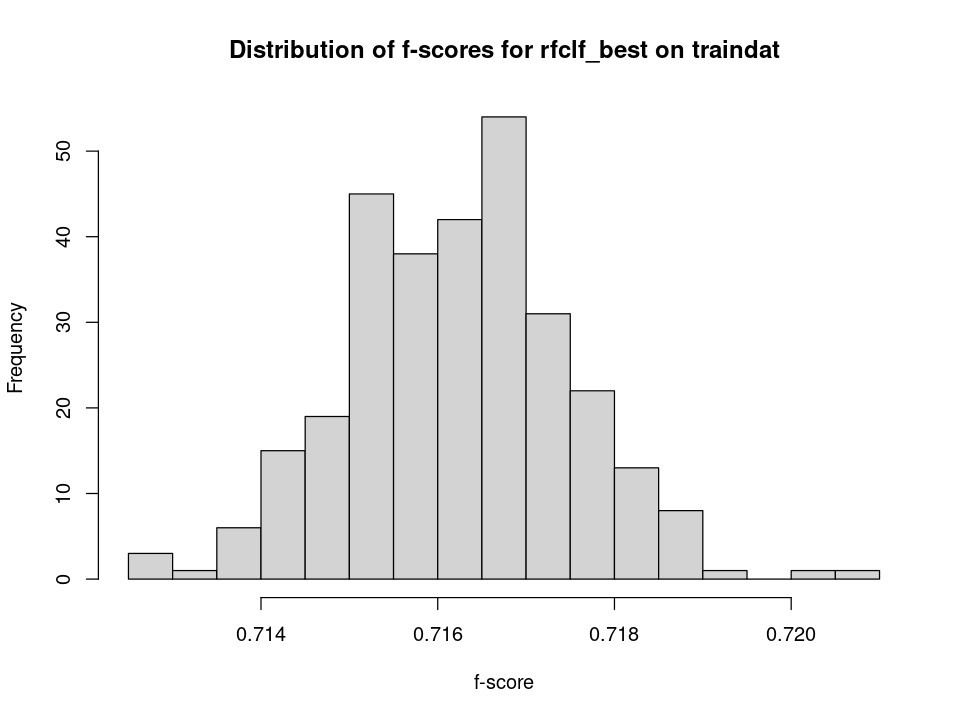

In [63]:
options(repr.plot.width= 8, repr.plot.height= 6)
hist(datout$fscore, breaks=12, xlab="f-score",
     main="Distribution of f-scores for rfclf_best on traindat")


In [64]:
# Get summaries for rfclf_best.

fn_avg <- mean(datout$FN)
fp_avg <- mean(datout$FP)

c(round(mean(datout$fscore), 4), round(mean(datout$Acc), 4),
  round(fn_avg, 2), round(fp_avg, 2))
# f-score:   0.7163   
# accuracy:  0.8303  
# false negatives: 1025  
# false positives: 771

# Type2: 0.7619


[1]    0.7163    0.8303 1025.1500  770.6700

In [65]:
round(mean(datout$Type2), 4)
# 0.7619


[1] 0.7619

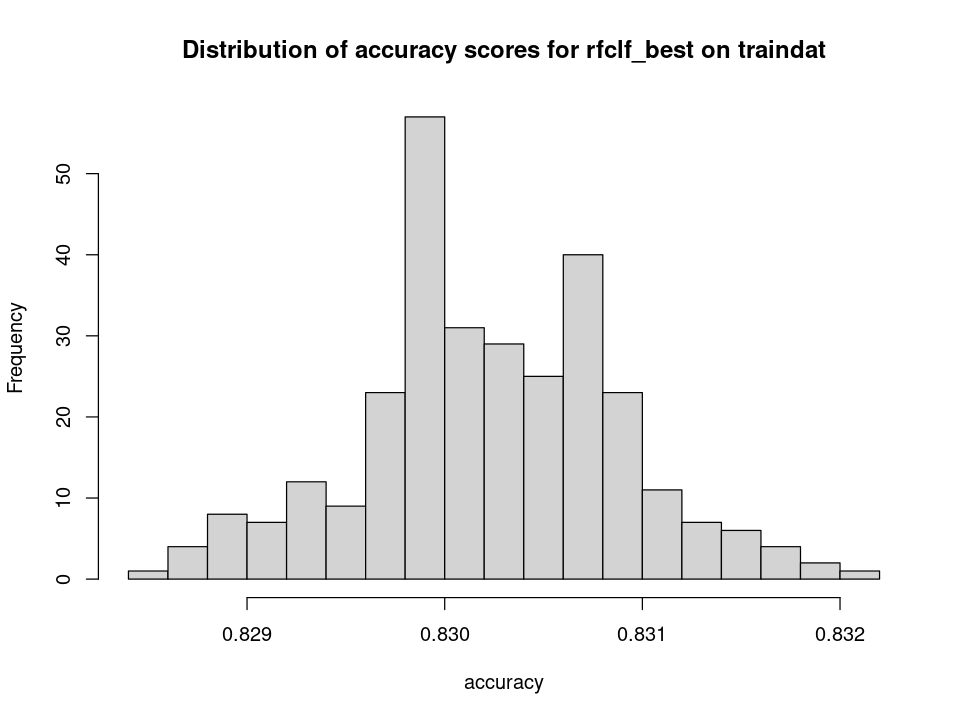

In [66]:
options(repr.plot.width= 8, repr.plot.height= 6)
hist(datout$Acc, breaks=14, xlab="accuracy",
     main="Distribution of accuracy scores for rfclf_best on traindat")


In [67]:
# Identify seeds with an accuracy score between 0.8295 
# and 0.8310.  When constructing rfclf_best, I will 
# use a seed which has an accuracy in the center of
# the distribution of accuracy scores.  (It may be that
# rfclf_best will generalize better to the test data if
# I choose a seed for it that is at the midpoint of the
# accuracy distribution.)

rf_candidate_seeds <- datout[which((datout$Acc > 0.8295) & (datout$Acc < 0.8310)),]$seed
length(rf_candidate_seeds)
#  226
head(rf_candidate_seeds)
#  9728   5605   5552   3837   2343   1219


[1] 226

[1] 9728 5605 5552 3837 2343 1219

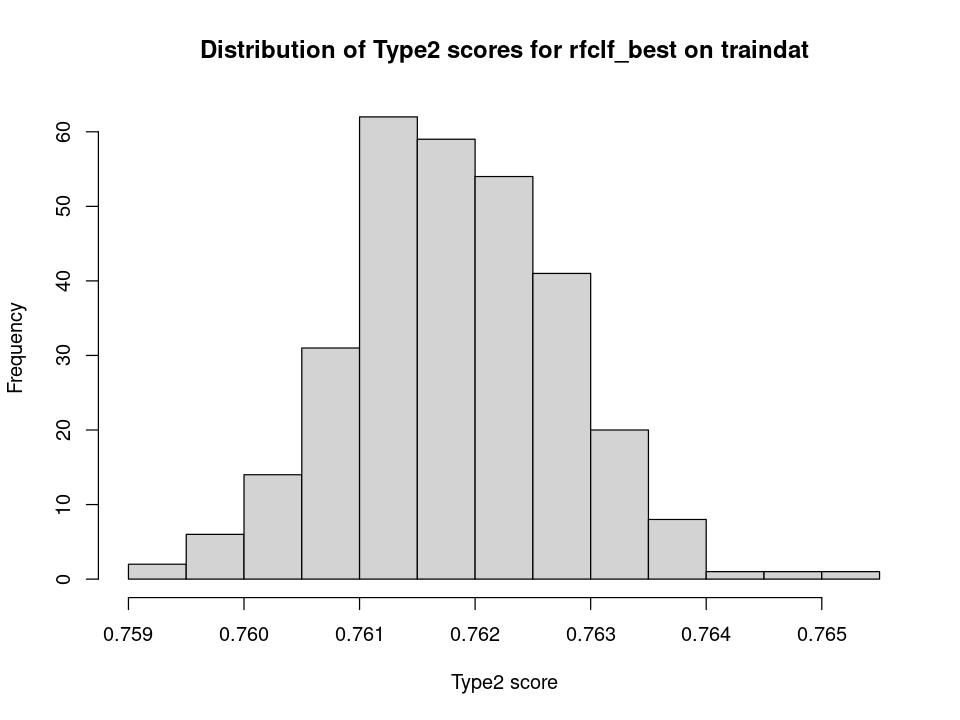

In [68]:
options(repr.plot.width= 8, repr.plot.height= 6)
hist(datout$Type2, breaks=16, xlab="Type2 score",
     main="Distribution of Type2 scores for rfclf_best on traindat")


In [70]:
# Get representative model.

set.seed(5552)
(rfclf_best <- randomForest(I(as.factor(Inland)) ~ ., 
                            data= traindat, ntree=500,
                            mtry= 1, nodesize= 3, importance=TRUE))



Call:
 randomForest(formula = I(as.factor(Inland)) ~ ., data = traindat,      ntree = 500, mtry = 1, nodesize = 3, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 1

        OOB estimate of  error rate: 16.87%
Confusion matrix:
     0    1 class.error
0 6544  767     0.10491
1 1022 2270     0.31045

In [71]:
print(round(rfclf_best$importance, 3))


                       0     1 MeanDecreaseAccuracy MeanDecreaseGini
housing_median_age 0.028 0.075                0.043           672.46
median_house_value 0.136 0.314                0.191          2570.13


## Get comparative scores for rfclf_best on testdat

In [74]:
# Function for obtaining a set of scores on the testset data
# using rfclf_best as the classifier.

get_testdatScores_rf <- function(seedv, dat) {
    
    seedv_len <- length(seedv)
    datout <- rep(NA, 5 * seedv_len)
    dim(datout) <- c(seedv_len, 5)
    datout <- as.data.frame(datout)
    colnames(datout) <- c("fscore","Acc","Type2", "FN","FP")
    rownames(datout) <- as.character(seedv)
    
    for(h in 1:seedv_len) {
        # shuffle dat
        cur_seed <- seedv[h]
        set.seed(cur_seed)
        # It is expected that dat is testdat, which has 10K rcds
        smp <- sample(rownames(dat), 4000, replace= FALSE)
        df <- dat[smp,]
    
        preds <- predict(rfclf_best, newdata= df, type="response")
        ans <- get_confusion(preds, df[, "Inland", drop=FALSE])
        
        mat <- as.matrix(ans[[1]])
        fscore <- round(as.numeric(ans[[2]]), 4)
        acc <- round(sum(diag(mat))/floor(sum(mat)), 4)
        type2 <- round((0.4 * acc + 0.6 * ans[[2]]), 4)
        FN <- as.numeric(mat[2,1])
        FP <- as.numeric(mat[1,2])
        datout[as.character(cur_seed), 1:5] <- c(fscore,acc,type2,FN,FP)
    }
    return(datout)
}


In [75]:
# Get rfclf_best's scores on the testset data.  For each of
# the 250 seeds, I sample 4K (no replacement) from the 10K
# set of testdat records.

set.seed(1821)
seed_vector <- sample(1:9999, 250, replace=FALSE)

start <- Sys.time()
paste0("Start time: ", start)
dat_result <- get_testdatScores_rf(seed_vector, testdat)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 44 secs


[1] "Start time: 2021-07-27 14:35:26"

Time difference of 43.34 secs

In [76]:
dim(dat_result)
head(dat_result)


[1] 250   5

,fscore,Acc,Type2,FN,FP
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5934,0.7144,0.8225,0.7576,383,327
1953,0.7089,0.8198,0.7533,412,309
7591,0.7083,0.8180,0.7522,397,331
1038,0.7131,0.8238,0.7574,376,329
49,0.7106,0.8168,0.7531,428,305
3203,0.7212,0.8245,0.7625,415,287


In [77]:
fscore_mean <- round(mean(dat_result$fscore), 4)
fscore_sd <- round(sd(dat_result$fscore), 4)
paste0("fscore mean: ", as.character(fscore_mean))
# 0.7156
paste0("fscore StdDev: ", as.character(fscore_sd))
# 0.0075
""
summary(dat_result$fscore)


[1] "fscore mean: 0.7156"

[1] "fscore StdDev: 0.0075"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.692   0.711   0.715   0.716   0.721   0.738 

In [78]:
Acc_mean <- round(mean(dat_result$Acc), 4)
Acc_sd <- round(sd(dat_result$Acc), 4)
paste0("accuracy mean: ", as.character(Acc_mean))
# 0.8228
paste0("accuracy StdDev: ", as.character(Acc_sd))
# 0.0045
""
summary(dat_result$Acc)


[1] "accuracy mean: 0.8228"

[1] "accuracy StdDev: 0.0045"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.812   0.820   0.823   0.823   0.826   0.835 

In [79]:
Type2_mean <- round(mean(dat_result$Type2), 4)
Type2_sd <- round(sd(dat_result$Type2), 4)
paste0("Type2 mean: ", as.character(Type2_mean))
# 0.7585
paste0("Type2 StdDev: ", as.character(Type2_sd))
# 0.0061
""
summary(dat_result$Type2)


[1] "Type2 mean: 0.7585"

[1] "Type2 StdDev: 0.0061"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.740   0.755   0.758   0.758   0.762   0.776 

In [80]:
FN_mean <- round(mean(dat_result$FN), 2)
FN_sd <- round(sd(dat_result$FN), 2)
paste0("FN mean: ", as.character(FN_mean))
# 403.8
paste0("FN StdDev: ", as.character(FN_sd))
# 14.48
""
summary(dat_result$FN)


[1] "FN mean: 403.8"

[1] "FN StdDev: 14.48"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    362     395     404     404     414     448 

In [81]:
FP_mean <- round(mean(dat_result$FP), 2)
FP_sd <- round(sd(dat_result$FP), 2)
paste0("FP mean: ", as.character(FP_mean))
# 304.86
paste0("FP StdDev: ", as.character(FP_sd))
#   12.4
""
summary(dat_result$FP)


[1] "FP mean: 304.86"

[1] "FP StdDev: 12.4"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    269     296     305     305     313     336 

## Find best gradient boosting model

,var,rel.inf
,<chr>,<dbl>
median_house_value,median_house_value,79.262
housing_median_age,housing_median_age,20.738


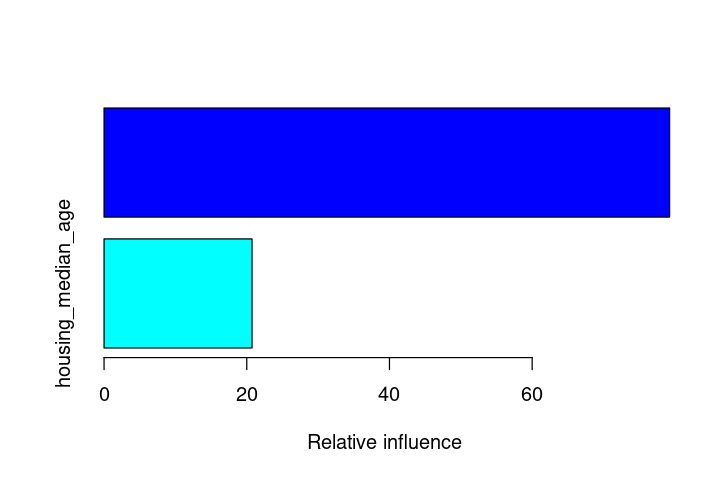

In [72]:
options(repr.plot.width= 6, repr.plot.height= 4)

set.seed(123)
gbmod <- gbm(Inland ~ ., data= traindat, n.trees= 1000,
                  distribution= "bernoulli", shrinkage= 0.1)
summary(gbmod)


In [73]:
preds <- suppressMessages(predict(gbmod, newdata= traindat, type="response"))
preds_transf <- preds
names(preds_transf) <- rownames(traindat)
preds_transf[which(preds_transf >= 0.5)] <- 1
preds_transf[which(preds_transf < 0.5)] <- 0
preds_transf <- as.factor(preds_transf)
ans <- get_confusion(preds_transf, traindat[, "Inland", drop=FALSE])
print(ans$matrix)
''
print(paste("f-score for gbmod: ", as.character(ans[[2]]), sep=""))
# 0.7292

# Accuracy is 0.8450

# Type2 is 0.7755


     0    1 class.error
0 6748  563      0.0770
1 1080 2212      0.3281


[1] ""

[1] "f-score for gbmod: 0.7292"


### Tune the gradient boosting model

In [83]:
# This function is called from get_cvScore_gb.

get_acc_gb <- function(traindat, valdat, ntrees, shrinkage) {
        
    gbmod <- gbm(Inland ~ ., data= traindat, n.trees=ntrees,
                  distribution= "bernoulli", shrinkage=shrinkage)
        
    preds <- suppressMessages(predict(gbmod, newdata= valdat, type="response"))
    names(preds) <- rownames(valdat)
    preds[which(preds >= 0.5)] <- 1
    preds[which(preds < 0.5)] <- 0
    preds <- as.factor(preds)
    ans <- get_confusion(preds, valdat[, "Inland", drop=FALSE])

    mat <- as.matrix(ans[[1]])
    mat[is.na(mat)] <- 0
    percent_correct <- round(sum(diag(mat))/floor(sum(mat)), 4)
    # result <- round((0.4 * percent_correct + 0.6 * ans[[2]]), 4)
    return(percent_correct)
}


In [85]:
# Function to obtain a cross-validation score, averaging the
# accuracy scores of the folds.  This function is called from
# avg_seedScores_gb.

get_cvScore_gb <- function(seed, dat, ntrees, shrinkage,
                           folds= 5) {
    
    # divide dat by the number of folds 
    segment_size <- round(dim(dat)[1]/folds)
    diff <- nrow(dat) - folds * segment_size
    last_seg_size <- segment_size + diff
    segmentsv <- c(rep(segment_size, (folds - 1)), last_seg_size)
    stopifnot(sum(segmentsv) == nrow(dat))
    
    # shuffle dat
    set.seed(seed)
    smp <- sample(rownames(dat), nrow(dat), replace= FALSE)
    dat <- dat[smp,]
    
    # split the data into the folds
    row_list <- vector("list", length= folds)
    names(row_list) <- as.character(1:folds)
    startpt <- 1
    for(i in 1:folds) {
        endpt <- startpt + segmentsv[i] - 1
        stopifnot(endpt <= dim(dat)[1])
        row_list[[i]] <- rownames(dat)[startpt:endpt]
        startpt <- endpt + 1
    }
    
    train_list <- test_list <- vector("list", length= folds)
    for(j in 1:folds) {
        testdat <- dat[row_list[[j]],]
        traindat <- dat[which(!(rownames(dat) %in% rownames(testdat))),]
        stopifnot((length(rownames(traindat)) + length(rownames(testdat))) == dim(dat)[1])
        test_list[[j]] <- testdat
        train_list[[j]] <- traindat
    }

    scores <- mcmapply(get_acc_gb, train_list, test_list,
                       MoreArgs= list(ntrees= ntrees, shrinkage=shrinkage),
                       SIMPLIFY= TRUE, mc.cores=5)
    
    # The average is of Type2 scores.
    return(round(mean(scores), 5))
}


In [86]:
# Since the seed value can have a big effect on the results,
# I take the average over a number of seeds.  This ftn is
# called from gridSearch03.

avg_seedScores_gb <- function(seed_vector, traindat, n_trees,  
                              shrinkage, folds= 5) {
    
    seed_len <- length(seed_vector)
    outv <- rep(NA, seed_len)
    for(i in 1:seed_len) {
        seed <- seed_vector[i]
        outv[i] <- get_cvScore_gb(seed, traindat, n_trees,
                                  shrinkage, folds=folds)
    }
    return(round(mean(outv), 5))
}


In [87]:
# This grid search is specific to finding the best gradient boosting
# classifier for traindat.

gridSearch03 <- function(seed_vector, traindat, ntree_vector, 
                         shrinkagev, folds=5) {
    
    tree_len <- length(ntree_vector)
    shrink_len <- length(shrinkagev)
    # We need to capture the gridSearch parameters as well as 
    # the cross-val  scores.
    datout <- rep(NA, 2 * tree_len * shrink_len)
    dim(datout) <- c((tree_len * shrink_len ), 2)
    datout <- as.data.frame(datout)
    colnames(datout) <- c("params", "Acc")
    datout$params <- ""
    
    index <- 0
    for(i in 1:tree_len) {
        n_trees <- ntree_vector[i]
        for(j in 1:shrink_len) {
            shrinkage <- shrinkagev[j]
            index <- index + 1
            param_string <- paste(as.character(n_trees), 
                                  as.character(shrinkage), sep= "--")
                datout$params[index] <- param_string
                datout$Acc[index] <- avg_seedScores_gb(seed_vector, traindat, n_trees, 
                                                         folds=folds, shrinkage=shrinkage)
        }
    }
    return(datout)
}


In [88]:
# Run grid search to get better parameters for the 
# gradient boosting model.  Test with 21 seeds.  For
# each seed, an average is taken over 5 folds.

set.seed(7543)
seed_smp <- sample(1:9999, 21, replace=FALSE)
tree_vector <- c(500, 750, 900)
shrinkage_v <- c(0.05, 0.08, 0.1, 0.15, 0.2)


start <- Sys.time()
paste("Start time: ", start, sep="")
ans <- gridSearch03(seed_smp, traindat, tree_vector, shrinkage_v)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 4 mins

(best_params <- ans[which(ans$Acc == max(ans$Acc)),]$params)
# '900--0.05'

(best_rf_Acc <- ans[which(ans$Acc == max(ans$Acc)),]$Acc)
# 0.8412


[1] "Start time: 2021-07-27 14:43:23"

Time difference of 3.94 mins

[1] "900--0.05"

[1] 0.84119

In [89]:
# Refine the search.

set.seed(7541)
seed_smp <- sample(1:9999, 21, replace=FALSE)
tree_vector <- c(900, 1100, 1300)
shrinkage_v <- c(0.01, 0.03, 0.05)


start <- Sys.time()
paste("Start time: ", start, sep="")
ans <- gridSearch03(seed_smp, traindat, tree_vector, shrinkage_v)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 3.5 mins

(best_params <- ans[which(ans$Acc == max(ans$Acc)),]$params)
# '1100--0.03'

(best_rf_Acc <- ans[which(ans$Acc == max(ans$Acc)),]$Acc)
# 0.8409


[1] "Start time: 2021-07-27 14:50:28"

Time difference of 3.44 mins

[1] "1100--0.03"

[1] 0.84094

In [90]:
# We might as well choose 900--0.05 since
# has a nearly equal score.

ans


params,Acc
<chr>,<dbl>
900--0.01,0.83980
900--0.03,0.84092
900--0.05,0.84092
1100--0.01,0.84021
1100--0.03,0.84094
1100--0.05,0.84090
1300--0.01,0.84037
1300--0.03,0.84086
1300--0.05,0.84082


### Get scores for gbclf_best on traindat

In [94]:
# Get stable scores for the best gradient boosting model. 
# I will refer to this model as gbclf_best.  Note that 
# 300 seeds are being used.

set.seed(1433)
seed_smp <- sample(1:9999, 300, replace=FALSE)

datout <- rep(NA, 6 * length(seed_smp))
dim(datout) <- c(length(seed_smp), 6)
datout <- as.data.frame(datout)
colnames(datout) <- c("seed","fscore","Acc","Type2", "FN","FP")
datout$seed <- seed_smp

start <- Sys.time()
for(i in 1:length(seed_smp)) {
    
    set.seed(seed_smp[i])
    gbmod <- gbm(Inland ~ ., data= traindat, n.trees=900,
                  distribution= "bernoulli", shrinkage=0.05)
        
    preds <- suppressMessages(predict(gbmod, newdata= traindat, type="response"))
    names(preds) <- rownames(traindat)
    preds[which(preds >= 0.5)] <- 1
    preds[which(preds < 0.5)] <- 0
    preds <- as.factor(preds)
    ans <- get_confusion(preds, traindat[, "Inland", drop=FALSE])
        
    mat <- as.matrix(ans[[1]])
    percent_correct <- sum(diag(mat))/floor(sum(mat))
    datout[i, c("Acc")] <- acc <- round(percent_correct, 4)
    datout[i, c("fscore")] <- fscore <- round(ans[[2]], 4)
    datout[i, c("Type2")] <- round(0.4*acc + 0.6*fscore, 4)
    datout[i, c("FN")] <- as.numeric(mat[2,1])
    datout[i, c("FP")] <- as.numeric(mat[1,2])
}
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 5 mins


Time difference of 5.01 mins

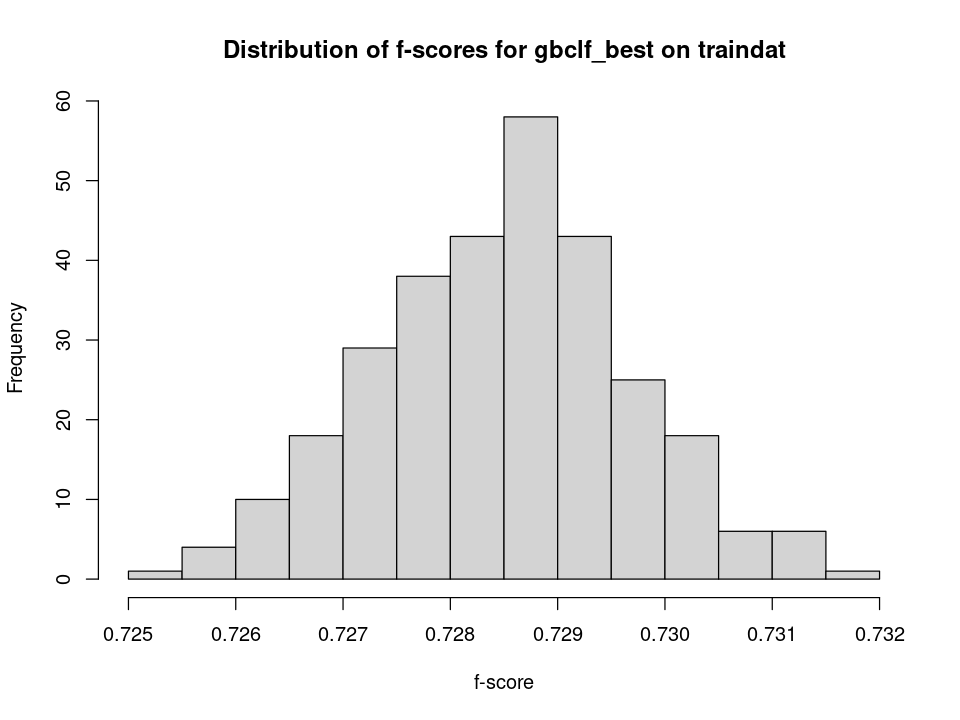

In [95]:
options(repr.plot.width= 8, repr.plot.height= 6)
hist(datout$fscore, breaks=12, xlab="f-score",
     main="Distribution of f-scores for gbclf_best on traindat")


In [96]:
# Get summaries for gbclf_best.

fn_avg <- mean(datout$FN)
fp_avg <- mean(datout$FP)

c(round(mean(datout$fscore), 4), round(mean(datout$Acc), 4),
  round(fn_avg, 2), round(fp_avg, 2))
# f-score:   0.7285   
# accuracy:  0.8444   
# false negatives: 1079   
# false positives: 571

# Type2: 0.7749


[1]    0.7285    0.8444 1078.6900  570.6600

In [97]:
round(mean(datout$Type2), 4)
# 0.7749


[1] 0.7749

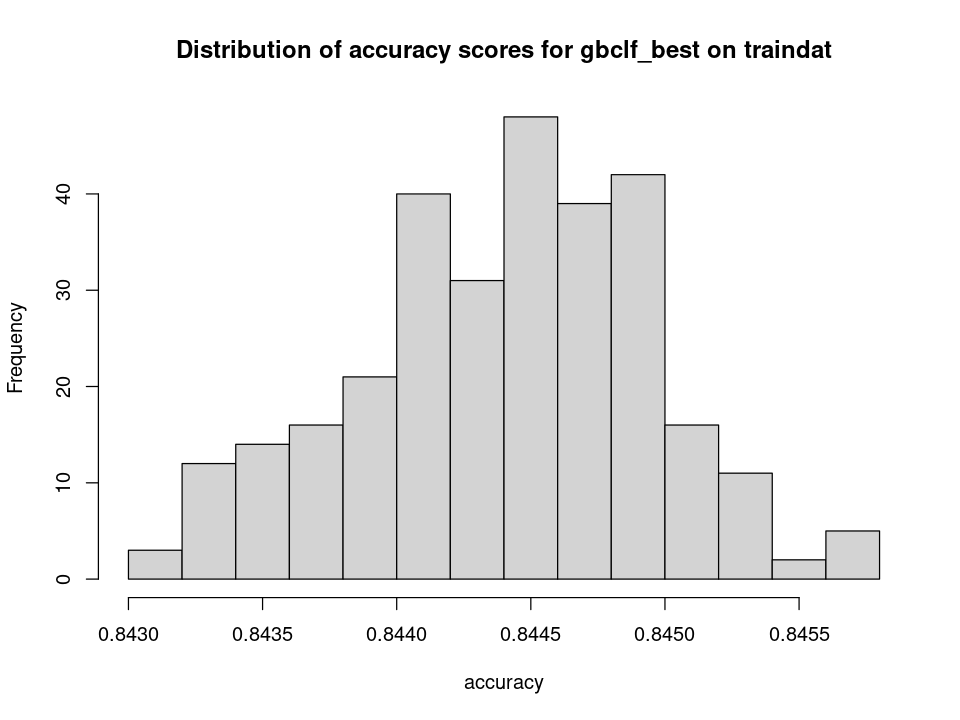

In [98]:
options(repr.plot.width= 8, repr.plot.height= 6)
hist(datout$Acc, breaks=16, xlab="accuracy",
     main="Distribution of accuracy scores for gbclf_best on traindat")


In [99]:
# Identify seeds with an accuracy score between 0.8442 
# and 0.8447.  When constructing gbclf_best, I will
# use a seed which has an accuracy in the center of
# the distribution of accuracy scores.  (It may be that
# gbclf_best will generalize better to the test data if
# I choose a seed for it that is at the midpoint of the
# accuracy distribution.)

gb_candidate_seeds <- datout[which((datout$Acc > 0.8442) & (datout$Acc < 0.8447)),]$seed
length(gb_candidate_seeds)
#  79
head(gb_candidate_seeds)
#  9728   3837   2551   1465   6565   7097 


[1] 79

[1] 9728 3837 2551 1465 6565 7097

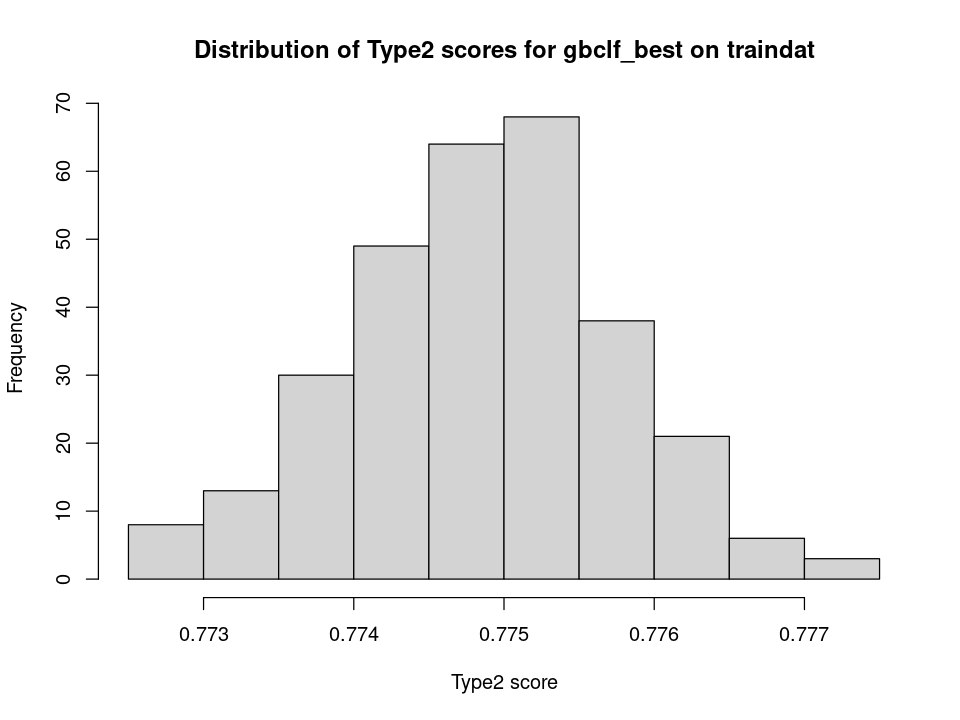

In [100]:
options(repr.plot.width= 8, repr.plot.height= 6)
hist(datout$Type2, breaks=14, xlab="Type2 score",
     main="Distribution of Type2 scores for gbclf_best on traindat")


,var,rel.inf
,<chr>,<dbl>
median_house_value,median_house_value,82.489
housing_median_age,housing_median_age,17.511


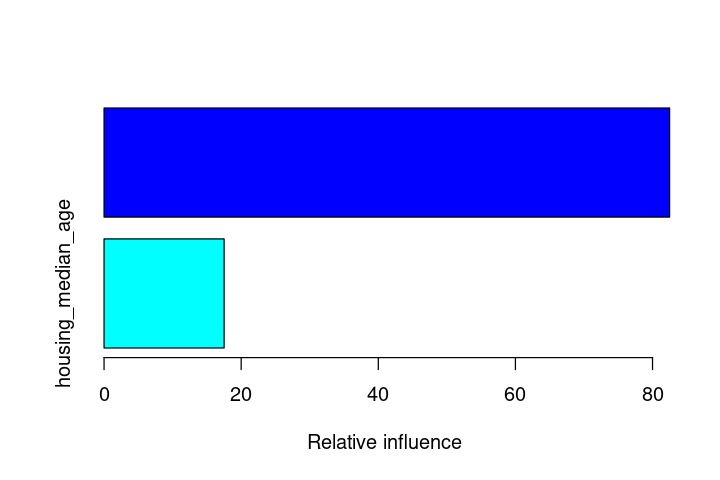

In [102]:
# Generate representative model.

set.seed(7097)
gbclf_best <- gbm(Inland ~ ., data= traindat, n.trees=900,
                  distribution= "bernoulli", shrinkage=0.05)

options(repr.plot.width= 6, repr.plot.height= 4)
summary(gbclf_best)


## Get comparative scores for gbclf_best on testdat

In [103]:
# Function for obtaining a set of scores on the testset data
# using gbclf_best as the classifier.

get_testdatScores_gb <- function(seedv, dat) {
    
    seedv_len <- length(seedv)
    datout <- rep(NA, 5 * seedv_len)
    dim(datout) <- c(seedv_len, 5)
    datout <- as.data.frame(datout)
    colnames(datout) <- c("fscore","Acc","Type2", "FN","FP")
    rownames(datout) <- as.character(seedv)
    
    for(h in 1:seedv_len) {
        # shuffle dat
        cur_seed <- seedv[h]
        set.seed(cur_seed)
        # It is expected that dat is testdat, which has 10K rcds
        smp <- sample(rownames(dat), 4000, replace= FALSE)
        df <- dat[smp,]
        
        preds <- suppressMessages(predict(gbclf_best, newdata= df, type="response"))
        names(preds) <- rownames(df)
        preds[which(preds >= 0.5)] <- 1
        preds[which(preds < 0.5)] <- 0
        preds <- as.factor(preds)
        ans <- get_confusion(preds, df[, "Inland", drop=FALSE])
        
        mat <- as.matrix(ans[[1]])
        fscore <- round(as.numeric(ans[[2]]), 4)
        acc <- round(sum(diag(mat))/floor(sum(mat)), 4)
        type2 <- round((0.4 * acc + 0.6 * ans[[2]]), 4)
        FN <- as.numeric(mat[2,1])
        FP <- as.numeric(mat[1,2])
        datout[as.character(cur_seed), 1:5] <- c(fscore,acc,type2,FN,FP)
    }
    return(datout)
}


In [104]:
# Get gbclf_best's scores on the testset data.  For each of
# the 250 seeds, I sample 4K (no replacement) from the 10K
# set of testdat records.

set.seed(1821)
seed_vector <- sample(1:9999, 250, replace=FALSE)

start <- Sys.time()
paste("Start time: ", start, sep="")
dat_result <- get_testdatScores_gb(seed_vector, testdat)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 11.4 secs


[1] "Start time: 2021-07-27 15:13:26"

Time difference of 11.43 secs

In [105]:
dim(dat_result)
head(dat_result)


[1] 250   5

,fscore,Acc,Type2,FN,FP
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5934,0.7220,0.8332,0.7665,405,262
1953,0.7087,0.8258,0.7555,442,255
7591,0.7230,0.8335,0.7672,412,254
1038,0.7200,0.8330,0.7652,393,275
49,0.7097,0.8212,0.7543,454,261
3203,0.7295,0.8358,0.7720,437,220


In [106]:
fscore_mean <- round(mean(dat_result$fscore), 4)
fscore_sd <- round(sd(dat_result$fscore), 4)
paste0("fscore mean: ", as.character(fscore_mean))
# 0.7183
paste0("fscore StdDev: ", as.character(fscore_sd))
# 0.0077
""
summary(dat_result$fscore)


[1] "fscore mean: 0.7183"

[1] "fscore StdDev: 0.0077"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.694   0.713   0.719   0.718   0.723   0.744 

In [107]:
Acc_mean <- round(mean(dat_result$Acc), 4)
Acc_sd <- round(sd(dat_result$Acc), 4)
paste0("accuracy mean: ", as.character(Acc_mean))
# 0.8304
paste0("accuracy StdDev: ", as.character(Acc_sd))
# 0.0044
""
summary(dat_result$Acc)


[1] "accuracy mean: 0.8304"

[1] "accuracy StdDev: 0.0044"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.820   0.828   0.831   0.830   0.833   0.842 

In [108]:
Type2_mean <- round(mean(dat_result$Type2), 4)
Type2_sd <- round(sd(dat_result$Type2), 4)
paste0("Type2 mean: ", as.character(Type2_mean))
# 0.7632
paste0("Type2 StdDev: ", as.character(Type2_sd))
# 0.0061
""
summary(dat_result$Type2)


[1] "Type2 mean: 0.7632"

[1] "Type2 StdDev: 0.0061"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.745   0.759   0.763   0.763   0.767   0.782 

In [109]:
FN_mean <- round(mean(dat_result$FN), 2)
FN_sd <- round(sd(dat_result$FN), 2)
paste0("FN mean: ", as.character(FN_mean))
# 430.03
paste0("FN StdDev: ", as.character(FN_sd))
# 14.69
""
summary(dat_result$FN)


[1] "FN mean: 430.03"

[1] "FN StdDev: 14.69"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    382     421     430     430     441     464 

In [110]:
FP_mean <- round(mean(dat_result$FP), 2)
FP_sd <- round(sd(dat_result$FP), 2)
paste0("FP mean: ", as.character(FP_mean))
# 248.52
paste0("FP StdDev: ", as.character(FP_sd))
# 11.69
""
summary(dat_result$FP)


[1] "FP mean: 248.52"

[1] "FP StdDev: 11.69"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    211     240     249     249     256     275 

In [ ]:
### COMMENT:

# gbclf_best has slightly better scores than rfclf_best.


## Find best logistic regression model

In [114]:
f01 <- glm(Inland ~ ., data=traindat, family=binomial())
summary(f01)
get_RsqrdDev(f01)



Call:
glm(formula = Inland ~ ., family = binomial(), data = traindat)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-2.370  -0.691  -0.250   0.697   4.884  

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)
(Intercept)         4.04e+00   1.05e-01    38.6   <2e-16
housing_median_age -5.53e-02   2.22e-03   -24.9   <2e-16
median_house_value -1.97e-05   4.60e-07   -42.8   <2e-16

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 13137  on 10602  degrees of freedom
Residual deviance:  8927  on 10600  degrees of freedom
AIC: 8933

Number of Fisher Scoring iterations: 6


[1] 0.4613

In [112]:
# Add power transformation.

f02 <- glm(Inland ~ housing_median_age + 
           I(log(median_house_value)), 
           data=df, family=binomial())
           
summary(f02)
get_RsqrdDev(f02)



Call:
glm(formula = Inland ~ housing_median_age + I(log(median_house_value)), 
    family = binomial(), data = df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-3.268  -0.619  -0.286   0.533   3.661  

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)
(Intercept)                41.10321    0.86028    47.8   <2e-16
housing_median_age         -0.06155    0.00235   -26.2   <2e-16
I(log(median_house_value)) -3.36644    0.07061   -47.7   <2e-16

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 13137  on 10602  degrees of freedom
Residual deviance:  8376  on 10600  degrees of freedom
AIC: 8382

Number of Fisher Scoring iterations: 6


[1] 0.5093

In [126]:
# Tweak power transformation.

f03 <- glm(Inland ~ I(housing_median_age^0.6) +
           I(median_house_value^-0.08),
           data=df, family=binomial())
           
summary(f03)
get_RsqrdDev(f03)



Call:
glm(formula = Inland ~ I(housing_median_age^0.6) + I(median_house_value^-0.08), 
    family = binomial(), data = df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-3.406  -0.612  -0.290   0.517   3.575  

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)
(Intercept)                 -40.3261     0.8587   -47.0   <2e-16
I(housing_median_age^0.6)    -0.3717     0.0138   -26.9   <2e-16
I(median_house_value^-0.08) 109.5732     2.2850    48.0   <2e-16

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 13136.8  on 10602  degrees of freedom
Residual deviance:  8334.4  on 10600  degrees of freedom
AIC: 8340

Number of Fisher Scoring iterations: 5


[1] 0.5128

### f03 model diagnostics

In [127]:
# Check for dispersion <> 1.

# We want the following value to NOT be considerably larger
# than 1.  If it is, then we have to use family= quasibinomial
# in our modeling. (See p.311 of Kabacoff's "R in Action".)

phi <- deviance(f03)/df.residual(f03)
print(round(phi, 3))


[1] 0.786


In [ ]:
### COMMENT:

# The f03 model has dispersion < 1.  This under-
# dispersion does not affect the parameter estimates.  
# But it means that the standard error estimates for 
# our model coefficients, as seen in the above summary, 
# are larger than what they should be.


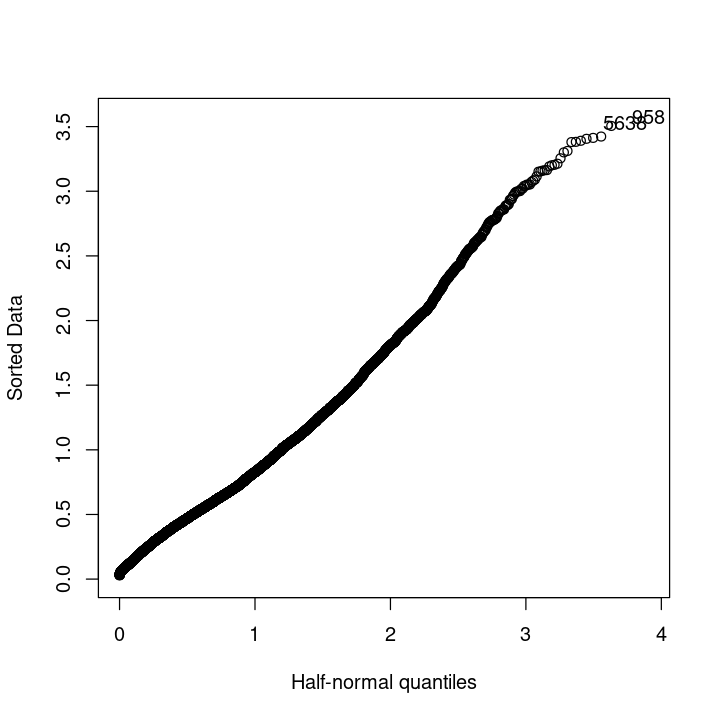

In [128]:
# Plot the residuals.  Julian Faraway's half-normal plot can
# be used to check for outliers.  See p.46 of Faraway's 
# "Extending the Linear Model with R".  The residuals plotted
# here are the deviance residuals.

options(repr.plot.width= 6, repr.plot.height= 6)

# Function halfnorm is from package faraway.
halfnorm(residuals(f03))


In [ ]:
### COMMENT:

# The diagnostics look ok for our purposes.


## Get comparative scores for f03 on testdat

In [129]:
# Function for obtaining a set of scores on the testset data
# using f03 as the classifier.

get_testdatScores_f03 <- function(seedv, dat) {
    
    seedv_len <- length(seedv)
    datout <- rep(NA, 5 * seedv_len)
    dim(datout) <- c(seedv_len, 5)
    datout <- as.data.frame(datout)
    colnames(datout) <- c("fscore","Acc","Type2", "FN","FP")
    rownames(datout) <- as.character(seedv)
    
    for(h in 1:seedv_len) {
        # shuffle dat
        cur_seed <- seedv[h]
        set.seed(cur_seed)
        # It is expected that dat is testdat, which has 10K rcds
        smp <- sample(rownames(dat), 4000, replace= FALSE)
        df <- dat[smp,]
        
        preds <- predict(f03, newdata= df)
        names(preds) <- rownames(df)
        preds[which(preds >= 0.5)] <- 1
        preds[which(preds < 0.5)] <- 0
        preds <- as.factor(preds)
        ans <- get_confusion(preds, df[, "Inland", drop=FALSE])
        
        mat <- as.matrix(ans[[1]])
        fscore <- round(as.numeric(ans[[2]]), 4)
        acc <- round(sum(diag(mat))/floor(sum(mat)), 4)
        type2 <- round((0.4 * acc + 0.6 * ans[[2]]), 4)
        FN <- as.numeric(mat[2,1])
        FP <- as.numeric(mat[1,2])
        datout[as.character(cur_seed), 1:5] <- c(fscore,acc,type2,FN,FP)
    }
    return(datout)
}


In [130]:
# Get f03's scores on the testset data.  For each of
# the 250 seeds, I sample 4K (no replacement) from the 10K
# set of testdat records.

set.seed(1821)
seed_vector <- sample(1:9999, 250, replace=FALSE)

start <- Sys.time()
# paste("Start time: ", start, sep="")
dat_result <- get_testdatScores_f03(seed_vector, testdat)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 5 secs


Time difference of 5.14 secs

In [131]:
dim(dat_result)
head(dat_result)


[1] 250   5

,fscore,Acc,Type2,FN,FP
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5934,0.6742,0.8270,0.7353,555,137
1953,0.6676,0.8208,0.7289,570,147
7591,0.6828,0.8300,0.7417,549,131
1038,0.6782,0.8285,0.7383,529,157
49,0.6588,0.8130,0.7205,606,142
3203,0.6676,0.8192,0.7282,597,126


In [132]:
fscore_mean <- round(mean(dat_result$fscore), 4)
fscore_sd <- round(sd(dat_result$fscore), 4)
paste0("fscore mean: ", as.character(fscore_mean))
# 0.6704
paste0("fscore StdDev: ", as.character(fscore_sd))
# 0.0090
""
summary(dat_result$fscore)


[1] "fscore mean: 0.6704"

[1] "fscore StdDev: 0.009"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.644   0.665   0.671   0.670   0.676   0.693 

In [133]:
Acc_mean <- round(mean(dat_result$Acc), 4)
Acc_sd <- round(sd(dat_result$Acc), 4)
paste0("accuracy mean: ", as.character(Acc_mean))
# 0.8226
paste0("accuracy StdDev: ", as.character(Acc_sd))
# 0.0046
""
summary(dat_result$Acc)


[1] "accuracy mean: 0.8226"

[1] "accuracy StdDev: 0.0046"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.810   0.819   0.823   0.823   0.826   0.836 

In [134]:
Type2_mean <- round(mean(dat_result$Type2), 4)
Type2_sd <- round(sd(dat_result$Type2), 4)
paste0("Type2 mean: ", as.character(Type2_mean))
# 0.7313
paste0("Type2 StdDev: ", as.character(Type2_sd))
# 0.0070
""
summary(dat_result$Type2)


[1] "Type2 mean: 0.7313"

[1] "Type2 StdDev: 0.007"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.712   0.727   0.732   0.731   0.736   0.748 

In [135]:
FN_mean <- round(mean(dat_result$FN), 2)
FN_sd <- round(sd(dat_result$FN), 2)
paste0("FN mean: ", as.character(FN_mean))
# 574
paste0("FN StdDev: ", as.character(FN_sd))
# 17.1
""
summary(dat_result$FN)


[1] "FN mean: 573.64"

[1] "FN StdDev: 17.08"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    523     563     573     574     585     617 

In [136]:
FP_mean <- round(mean(dat_result$FP), 2)
FP_sd <- round(sd(dat_result$FP), 2)
paste0("FP mean: ", as.character(FP_mean))
# 136
paste0("FP StdDev: ", as.character(FP_sd))
# 8.3
""
summary(dat_result$FP)


[1] "FP mean: 136.04"

[1] "FP StdDev: 8.27"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    114     131     136     136     142     162 

In [ ]:
### COMMENT:

# f03 does a great job avoiding false positives.
# But it has a high number of false negatives. 
# Overall, it is not as good a model as either 
# rfclf_best or gbclf_best.


## Find best SVM

In [138]:
# We need to center and scale the data. 

svm_scaled <- scale(traindat[, -1])
svm_centers <- attr(svm_scaled, "scaled:center")
svm_scales <- attr(svm_scaled, "scaled:scale")
svm_scaled <- as.data.frame(cbind(as.numeric(traindat$Inland), svm_scaled),
                            row.names=rownames(traindat))
colnames(svm_scaled) <- colnames(traindat)


In [140]:
# Test out a support vector machine.  Try kernel =
# radial basis function.

svm01 <- svm(I(as.factor(Inland)) ~ ., data=svm_scaled, kernel="radial",
             gamma= 0.1, cost= 100, scale=FALSE)

pred <- fitted(svm01)
(ans <- table(pred, as.factor(svm_scaled$Inland)))
get_fscore(as.matrix(ans))


    
pred    0    1
   0 6777 1182
   1  534 2110

[1] 0.7109

In [147]:
# Function to compute an accuracy score for an svm cv-fold.

get_acc_svm <- function(traindat, valdat, gamma, cost) {
    
    # traindat and valdat need to be scaled
    train_scaled <- scale(traindat[, -1])
    train_centers <- attr(train_scaled, "scaled:center")
    train_scales <- attr(train_scaled, "scaled:scale")
    train_scaled <- as.data.frame(cbind(as.numeric(traindat$Inland), train_scaled),
                                  row.names=rownames(traindat))
    colnames(train_scaled) <- colnames(traindat)
    
    svmmod <- svm(I(as.factor(Inland)) ~ ., data= train_scaled, gamma=gamma,
                    cost=cost, scale=FALSE, kernel="radial")
    
    # Scale valdat.
    valdat_scaled <- scale(valdat[, -1], center=train_centers,
                         scale=train_scales)
    valdat_scaled <- as.data.frame(valdat_scaled, 
                                   row.names=rownames(valdat),
                                   col.names=colnames(valdat))
    
    preds <- predict(svmmod, newdata= valdat_scaled)
    ans <- table(preds, as.factor(valdat$Inland))

    mat <- as.matrix(ans)
    mat[is.na(mat)] <- 0
    percent_correct <- round(sum(diag(mat))/floor(sum(mat)), 4)
    # result <- round((0.4 * percent_correct + 0.6 * get_fscore(mat)), 4)
    return(percent_correct)
}


In [145]:
# This grid search searches for the best parameters for svm
# modeling of the data.  It takes a vector of seeds.

gridSearch_svm <- function(seedv, dat, gammav, costv, folds=5) {
    
    gamma_len <- length(gammav)
    cost_len <- length(costv)
    # We need to capture the gridSearch parameters as well as 
    # the cross-val  scores.
    datout <- rep(NA, 2 * gamma_len * cost_len)
    dim(datout) <- c((gamma_len * cost_len), 2)
    datout <- as.data.frame(datout)
    colnames(datout) <- c("params", "Acc")
    datout$params <- ""
    
    # Divide dat by the number of folds to get a
    # size for each fold.
    segment_size <- round(nrow(dat)/folds)
    diff <- nrow(dat) - folds * segment_size
    last_seg_size <- segment_size + diff
    segmentsv <- c(rep(segment_size, (folds - 1)), last_seg_size)
    stopifnot(sum(segmentsv) == nrow(dat))
    
    index <- 0
    for(i in 1:gamma_len) {
        gamma <- gammav[i]
        for(j in 1:cost_len) {
            index <- index + 1
            cost <- costv[j]
            param_string <- paste(as.character(gamma), 
                                  as.character(cost), sep= "--")
            datout$params[index] <- param_string
            
            # Each set of parameters gets tested over many folds.
            # The different folds are created using different seeds.
    
            # Create a vector to store the accuracy score for each seed.
            seedv_len <- length(seedv)
            seed_scores <- rep(NA, seedv_len)
    
            for(h in 1:seedv_len) {
                # shuffle dat
                cur_seed <- seedv[h]
                set.seed(cur_seed)
                smp <- sample(rownames(dat), nrow(dat), replace= FALSE)
                dat <- dat[smp,]
    
                # Each element of row_list will be the rows we pick
                # out for one of the folds.  E.g., the first element
                # of row_list will contain the rows we want for the
                # first fold, the second element of row_list will
                # contain the rows we want for the second fold, and
                # so forth.
                row_list <- vector("list", length=folds)
                names(row_list) <- as.character(1:folds)
                startpt <- 1
                for(k in 1:folds) {
                    endpt <- startpt + segmentsv[k] - 1
                    stopifnot(endpt <= nrow(dat))
                    row_list[[k]] <- rownames(dat)[startpt:endpt]
                    startpt <- endpt + 1
                }
            
                train_list <- test_list <- vector("list", length= folds)
                for(k in 1:folds) {
                    testdat <- dat[row_list[[k]],]
                    traindat <- dat[which(!(rownames(dat) %in% rownames(testdat))),]
                    stopifnot((length(rownames(traindat)) + length(rownames(testdat))) == nrow(dat))
                    test_list[[k]] <- testdat
                    train_list[[k]] <- traindat
                }
                # When there are only 5 folds, only 5 cores get used.
                scores <- mcmapply(get_acc_svm, train_list, test_list,
                                   MoreArgs= list(gamma=gamma, cost=cost),
                                   SIMPLIFY= TRUE, mc.cores=5)
                # For the current seed, store the average of the Acc
                # scores, the average taken over the folds.
                seed_scores[h] <- round(mean(scores), 5)
        
            } ## end of for-loop, index h
            
            # Here I am taking an average of average scores.  This
            # could be improved by simply taking a single average.
            datout$Acc[index] <- round(mean(seed_scores), 5)
            
        } ## end of for-loop, index j
    } ## end of for-loop, index i
    
    return(datout)
}


In [149]:
# Run grid search to get better parameters for the 
# svm classifier.

set.seed(7543)
seed_vector <- sample(1:9999, 5, replace=FALSE)

gamma_v <- seq(0.02, 0.1, by=0.02)
cost_v <- seq(50, 200, by=50)

start <- Sys.time()
paste("Start time: ", start, sep="")
ans <- gridSearch_svm(seed_vector, traindat, gamma_v, cost_v)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 5 mins (with 5 seeds)

(best_params <- ans[which(ans$Acc == max(ans$Acc)),]$params)
# '0.02--50'

(best_Acc <- ans[which(ans$Acc == max(ans$Acc)),]$Acc)
# 0.8396


[1] "Start time: 2021-07-27 15:52:54"

Time difference of 4.51 mins

[1] "0.02--50"

[1] 0.83964

In [151]:
# Refine the grid search.

set.seed(7541)
seed_vector <- sample(1:9999, 21, replace=FALSE)

gamma_v <- seq(0.01, 0.02, by=0.01)
cost_v <- c(35, 50)

start <- Sys.time()
# paste("Start time: ", start, sep="")
ans <- gridSearch_svm(seed_vector, traindat, gamma_v, cost_v)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 3 mins (with 5 seeds)

(best_params <- ans[which(ans$Acc == max(ans$Acc)),]$params)
# '0.02--35'

(best_Acc <- ans[which(ans$Acc == max(ans$Acc)),]$Acc)
# 0.8399


Time difference of 3.1 mins

[1] "0.02--35"

[1] 0.83994

In [ ]:
#&* Bookmark

In [152]:
# Construct an svm with the identified parameters.

# We need to get probability estimates from the output.
## Note the use of svm_scaled (which is just svmtrain, scaled)
svm02 <- svm(I(as.factor(Inland)) ~ ., data=svm_scaled, kernel="radial",
               gamma=0.02, cost=35, scale=FALSE, probability=TRUE)

pred <- fitted(svm02)
(ans <- table(pred, as.factor(svm_scaled$Inland)))
print(paste("f-score for 'best' svm classifier, trainset: ", 
            as.character(get_fscore(as.matrix(ans))), sep=""))
# 0.7236

# Accuracy is 0.8400

# Type2 is 0.7702


    
pred    0    1
   0 6687 1072
   1  624 2220

[1] "f-score for 'best' svm classifier, trainset: 0.7236"


## Get comparative scores for svm02 on testdat

In [153]:
# Function for obtaining a set of scores on the testset data
# using svm02 as the classifier.

get_testdatScores_svm02 <- function(seedv, dat) {
    
    seedv_len <- length(seedv)
    datout <- rep(NA, 5 * seedv_len)
    dim(datout) <- c(seedv_len, 5)
    datout <- as.data.frame(datout)
    colnames(datout) <- c("fscore","Acc","Type2", "FN","FP")
    rownames(datout) <- as.character(seedv)
    
    for(h in 1:seedv_len) {
        # shuffle dat
        cur_seed <- seedv[h]
        set.seed(cur_seed)
        # It is expected that dat is testdat, which has 10K rcds
        smp <- sample(rownames(dat), 4000, replace= FALSE)
        df <- dat[smp,]
        
        df_scaled <- scale(df[, -1], center=svm_centers,
                        scale=svm_scales)
        df_scaled <- as.data.frame(cbind(as.numeric(df$Inland),df_scaled), 
                                   row.names=rownames(df))
        colnames(df_scaled) <- colnames(df)
        
        preds <- predict(svm02, newdata=df_scaled, scale=FALSE, probability=TRUE)
        preds_transf <- as.numeric(attr(preds, "probabilities")[, 2])
        names(preds_transf) <- rownames(df)
        preds_transf[which(preds_transf >= 0.5)] <- 1
        preds_transf[which(preds_transf < 0.5)] <- 0
        preds_transf <- as.factor(preds_transf)
        ans <- get_confusion(preds_transf, df[, "Inland", drop=FALSE])
        
        mat <- as.matrix(ans[[1]])
        mat[is.na(mat)] <- 0
        fscore <- round(as.numeric(ans[[2]]), 4)
        acc <- round(sum(diag(mat))/floor(sum(mat)), 4)
        type2 <- round((0.4 * acc + 0.6 * ans[[2]]), 4)
        FN <- as.numeric(mat[2,1])
        FP <- as.numeric(mat[1,2])
        datout[as.character(cur_seed), 1:5] <- c(fscore,acc,type2,FN,FP)
    }
    return(datout)
}


In [154]:
# Get svm02's scores on the testset data.  For each of
# the 250 seeds, I sample 4K (no replacement) from the 10K
# set of testdat records.

set.seed(1821)
seed_vector <- sample(1:9999, 250, replace=FALSE)

start <- Sys.time()
# paste("Start time: ", start, sep="")
dat_result <- get_testdatScores_svm02(seed_vector, testdat)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 58 secs


Time difference of 57.92 secs

In [155]:
dim(dat_result)
head(dat_result)


[1] 250   5

,fscore,Acc,Type2,FN,FP
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5934,0.7167,0.8310,0.7624,416,260
1953,0.7165,0.8295,0.7617,428,254
7591,0.7214,0.8338,0.7664,420,245
1038,0.7170,0.8315,0.7628,398,276
49,0.7091,0.8208,0.7538,454,263
3203,0.7267,0.8348,0.7699,444,217


In [156]:
fscore_mean <- round(mean(dat_result$fscore), 4)
fscore_sd <- round(sd(dat_result$fscore), 4)
paste0("fscore mean: ", as.character(fscore_mean))
# 0.7175
paste0("fscore StdDev: ", as.character(fscore_sd))
# 0.0078
""
summary(dat_result$fscore)


[1] "fscore mean: 0.7175"

[1] "fscore StdDev: 0.0078"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.694   0.713   0.717   0.718   0.723   0.741 

In [157]:
Acc_mean <- round(mean(dat_result$Acc), 4)
Acc_sd <- round(sd(dat_result$Acc), 4)
paste0("accuracy mean: ", as.character(Acc_mean))
# 0.8306
paste0("accuracy StdDev: ", as.character(Acc_sd))
# 0.0044
""
summary(dat_result$Acc)


[1] "accuracy mean: 0.8306"

[1] "accuracy StdDev: 0.0044"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.819   0.828   0.831   0.831   0.834   0.842 

In [158]:
Type2_mean <- round(mean(dat_result$Type2), 4)
Type2_sd <- round(sd(dat_result$Type2), 4)
paste0("Type2 mean: ", as.character(Type2_mean))
# 0.7628
paste0("Type2 StdDev: ", as.character(Type2_sd))
# 0.0062
""
summary(dat_result$Type2)


[1] "Type2 mean: 0.7628"

[1] "Type2 StdDev: 0.0062"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.745   0.759   0.763   0.763   0.767   0.780 

In [159]:
FN_mean <- round(mean(dat_result$FN), 2)
FN_sd <- round(sd(dat_result$FN), 2)
paste0("FN mean: ", as.character(FN_mean))
# 434
paste0("FN StdDev: ", as.character(FN_sd))
# 14.6
""
summary(dat_result$FN)


[1] "FN mean: 434.43"

[1] "FN StdDev: 14.59"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    389     425     435     434     444     474 

In [160]:
FP_mean <- round(mean(dat_result$FP), 2)
FP_sd <- round(sd(dat_result$FP), 2)
paste0("FP mean: ", as.character(FP_mean))
# 243
paste0("FP StdDev: ", as.character(FP_sd))
#  11.1
""
summary(dat_result$FP)


[1] "FP mean: 243.31"

[1] "FP StdDev: 11.14"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    214     236     244     243     251     276 

In [ ]:
### COMMENT:

# svm02's performance is equal to that of gbclf_best.


# Section 2: Model data with k-means

In [162]:
# We need to first scale the data.

kmtrain_scaled <- scale(traindat[, -1], center=TRUE, scale=TRUE)
kmtrain_centers <- attr(kmtrain_scaled, "scaled:center")
kmtrain_scales <- attr(kmtrain_scaled, "scaled:scale")

# Map the values into the range [0, 1].  (I am not 
# sure whether this makes things better or worse.)
kmtrain_scaled <- apply(kmtrain_scaled, MARGIN=2, range01)
summary(kmtrain_scaled)
kmtrain_scaled <- as.data.frame(cbind(as.numeric(traindat$Inland), kmtrain_scaled),
                            row.names=rownames(traindat))
colnames(kmtrain_scaled) <- colnames(traindat)


 housing_median_age median_house_value
 Min.   :0.000      Min.   :0.000     
 1st Qu.:0.233      1st Qu.:0.138     
 Median :0.384      Median :0.216     
 Mean   :0.385      Mean   :0.258     
 3rd Qu.:0.493      3rd Qu.:0.328     
 Max.   :1.000      Max.   :1.000     

## Construct initial k-means model

In [163]:
# Run k-means algorithm with number of clusters set to 2.
# Make sure to remove the Inland column.

set.seed(1233)
start <- Sys.time()
km_mod <- kmeans(kmtrain_scaled[, -1], 2, iter.max = 50, nstart = 15)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 0.04 secs

print(km_mod$size)


Time difference of 0.05 secs

[1] 5139 5464


In [164]:
datout <- as.data.frame(cbind(kmtrain_scaled$Inland, km_mod$cluster))
colnames(datout) <- c("Inland", "cluster")
rownames(datout) <- rownames(kmtrain_scaled)
head(datout)


,Inland,cluster
,<dbl>,<dbl>
15111,0,2
20002,1,2
13570,1,1
20333,0,2
10614,0,2
18538,0,2


In [166]:
# max_vals identifies the Inland level we would expect 
# each cluster to map to.

(mat <- as.matrix(table(datout$Inland, as.factor(datout$cluster))))
max_vals <- apply(mat, MARGIN=2, which.max); print(max_vals)


   
       1    2
  0 4227 3084
  1  912 2380

1 2 
1 1 


In [167]:
# Use function c1_toLevel_1 to get the correct 
# mapping between clusters and Inland levels.

c1_to_Inland1 <- c1_toLevel_1(datout)

paste("Map cluster 1 to Inland level 1? :  ", c1_to_Inland1, sep="")


[1] "Map cluster 1 to Inland level 1? :  FALSE"

In [171]:
tmpdat <- datout
tmpdat[which(tmpdat$cluster== 1),]$Inland <- 0
tmpdat[which(tmpdat$cluster== 2),]$Inland <- 1
dim(tmpdat)


[1] 10603     2

In [172]:
sum(rownames(tmpdat) == rownames(kmtrain_scaled)) == nrow(kmtrain_scaled)
table(as.factor(tmpdat$Inland))


[1] TRUE


   0    1 
5139 5464 

In [173]:
# Get initial set of scores for the k-means base model.

preds <- as.factor(tmpdat$Inland)
names(preds) <- rownames(tmpdat)
ans <- get_confusion(preds, kmtrain_scaled[, "Inland", drop=FALSE])
print(ans$matrix)
''
print(paste("f-score for k-means base model on training set: ", as.character(ans[[2]]), sep=""))
# f-score: 0.5436

# Accuracy: 0.6231

# Type2: 0.5754


     0    1 class.error
0 4227 3084      0.4218
1  912 2380      0.2770


[1] ""

[1] "f-score for k-means base model on training set: 0.5436"


In [ ]:
### COMMENT:

# The k-means algorithm has difficulty with this dataset.
# We see from the following wss plot that k-means would 
# do somewhat better if we asked it to find 3 clusters, not
# 2.


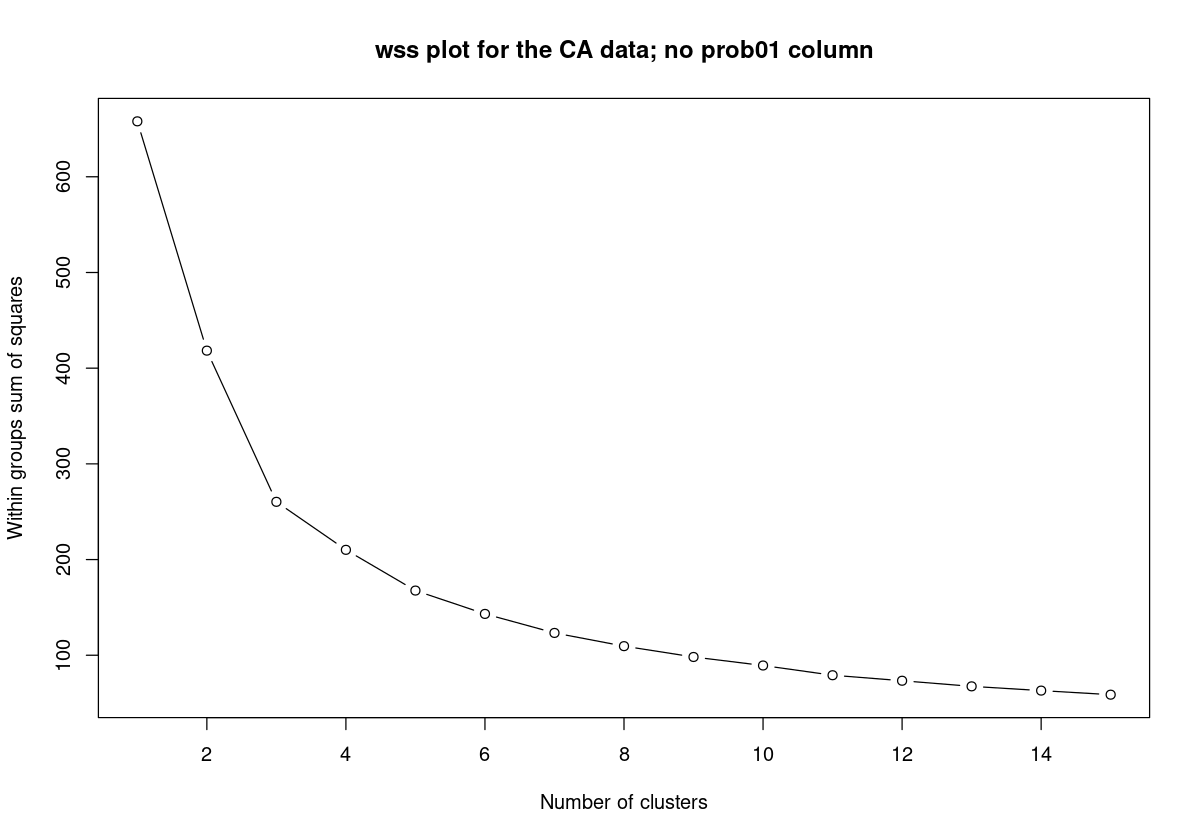

In [174]:
# See whether 2 clusters makes sense for this dataframe.

options(repr.plot.width= 10, repr.plot.height= 7)

wssplot(kmtrain_scaled[, -1], title= "wss plot for the CA data; no prob01 column")


In [ ]:
### COMMENT:

# The wss plot suggests that a more natural solution
# might be 3 clusters rather than 2.

# So, unlike the downer cow data, there is not a natural
# ordering into 2 subgroups.  Recall that with the cow data
# the specific purpose of collecting variables such as 
# AST and CK was to see if they could help in distinguishing
# the surviving cows from the non-survivors.  By contrast, 
# the CA housing variables I am working with were not 
# collected with the purpose of distinguishing Inland 
# districts from districts closer to the ocean.  So it is 
# reasonable that a 2-cluster solution is not obvious.


## Construct hybrid k-means model with prob01 from f03

If a hybrid model exists which outperforms the other models we have surveyed (namely svm02 and gbclf_best, since they have the best sets of scores), it very likely will require at least 2 probability columns.  The first will be needed simply to nudge k-means to a 2-cluster solution.  The second might then be able to further boost the hybrid model's scores.

For the first probability column I will use the weakest model, f03, not because it is the weakest but rather because it so clearly differs from the other models, having far fewer false positives.  Then for prob02 I can choose between gbclf_best and svm02.



In [177]:
# Add a prob01 column to kmtrain.

preds <- predict(f03, newdata=traindat, type="response")

kmtrain_scaled$prob01 <- preds
summary(kmtrain_scaled$prob01)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00042 0.05881 0.19012 0.31048 0.53251 0.99946 

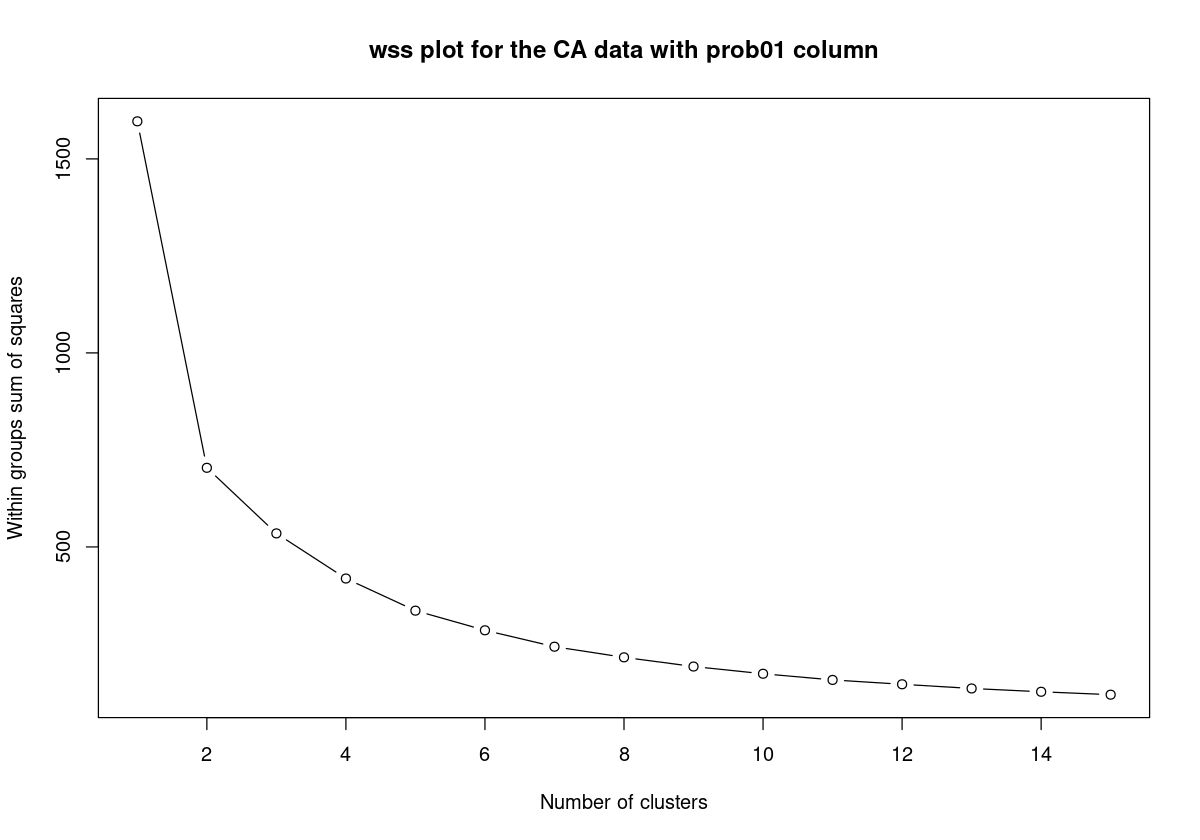

In [178]:
# See if a 2-cluster solution now makes more sense.

options(repr.plot.width= 10, repr.plot.height= 7)

suppressMessages(wssplot(kmtrain_scaled[, -1], 
        title= "wss plot for the CA data with prob01 column"))


In [ ]:
### COMMENT:

# This is exactly the kind of curve we want to see if
# we want to partition the data into 2 clusters.


### Get scores on trainset for k-means with prob01, no weights

In [179]:
# Run k-means algorithm with number of clusters set to 2.

set.seed(1233)
start <- Sys.time()
kmp1 <- kmeans(kmtrain_scaled[, -1], 2, iter.max = 50, nstart = 15)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 0.03 secs

print(kmp1$size)


Time difference of 0.04 secs

[1] 6955 3648


In [180]:
datout <- as.data.frame(cbind(kmtrain_scaled$Inland, kmp1$cluster))
colnames(datout) <- c("Inland", "cluster")
rownames(datout) <- rownames(kmtrain_scaled)

c1_to_Inland1 <- c1_toLevel_1(datout)

paste("Map cluster 1 to Inland level 1? :  ", c1_to_Inland1, sep="")


[1] "Map cluster 1 to Inland level 1? :  FALSE"

In [181]:
tmpdat <- datout
tmpdat[which(tmpdat$cluster== 1),]$Inland <- 0
tmpdat[which(tmpdat$cluster== 2),]$Inland <- 1
dim(tmpdat)


[1] 10603     2

In [182]:
sum(rownames(tmpdat) == rownames(kmtrain_scaled)) == nrow(kmtrain_scaled)
table(as.factor(tmpdat$Inland))


[1] TRUE


   0    1 
6955 3648 

In [183]:
# Get initial set of scores for the k-means hybrid model 
# with prob01 built from g03.

preds <- as.factor(tmpdat$Inland)
names(preds) <- rownames(tmpdat)
ans <- get_confusion(preds, kmtrain_scaled[, "Inland", drop=FALSE])
print(ans$matrix)
''
print(paste("f-score for k-means hybrid model on training set: ", as.character(ans[[2]]), sep=""))
# f-score: 0.7352

# Accuracy: 0.8267

# Type2: 0.7718


     0    1 class.error
0 6214 1097      0.1500
1  741 2551      0.2251


[1] ""

[1] "f-score for k-means base model on training set: 0.7352"


## Add a prob02 column using gbclf_best

In [185]:
# Add a prob02 column to kmtrain.

preds <- suppressMessages(predict(gbclf_best, newdata=traindat, type="response"))

kmtrain_scaled$prob02 <- preds
summary(kmtrain_scaled$prob02)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00873 0.06008 0.16665 0.31080 0.53070 0.99635 

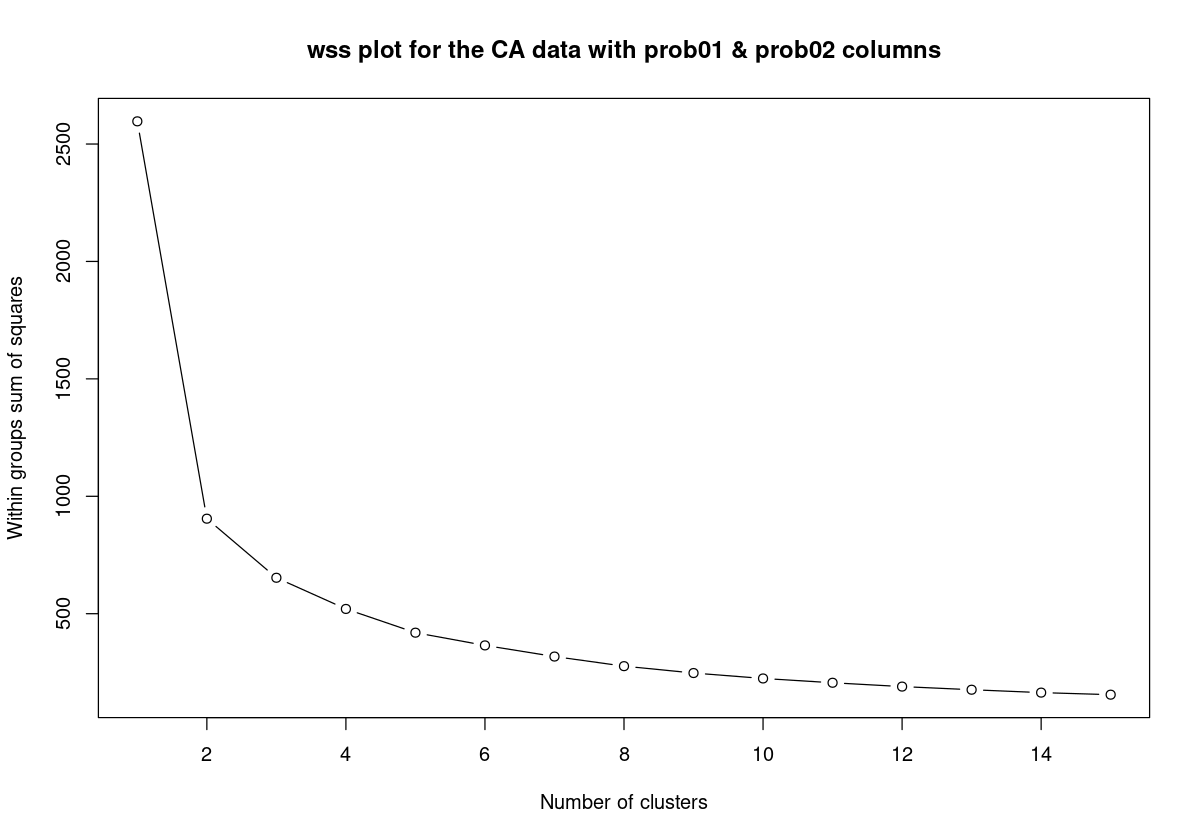

In [186]:
# See if the wss plot changes.

options(repr.plot.width= 10, repr.plot.height= 7)

suppressMessages(wssplot(kmtrain_scaled[, -1], 
        title= "wss plot for the CA data with prob01 & prob02 columns"))


### Get scores on trainset for k-means with prob01 & prob02, no weights

In [193]:
# Run k-means algorithm with number of clusters set to 2.

set.seed(1233)
start <- Sys.time()
kmp1p2 <- kmeans(kmtrain_scaled[, -1], 2, iter.max = 50, nstart = 15)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 0.03 secs

print(kmp1p2$size)


Time difference of 0.04 secs

[1] 7228 3375


In [194]:
datout <- as.data.frame(cbind(kmtrain_scaled$Inland, kmp1p2$cluster))
colnames(datout) <- c("Inland", "cluster")
rownames(datout) <- rownames(kmtrain_scaled)

c1_to_Inland1 <- c1_toLevel_1(datout)

paste("Map cluster 1 to Inland level 1? :  ", c1_to_Inland1, sep="")


[1] "Map cluster 1 to Inland level 1? :  FALSE"

In [189]:
tmpdat <- datout
tmpdat[which(tmpdat$cluster== 1),]$Inland <- 0
tmpdat[which(tmpdat$cluster== 2),]$Inland <- 1
dim(tmpdat)


[1] 10603     2

In [190]:
sum(rownames(tmpdat) == rownames(kmtrain_scaled)) == nrow(kmtrain_scaled)
table(as.factor(tmpdat$Inland))


[1] TRUE


   0    1 
7228 3375 

In [191]:
# Get initial set of scores for the k-means hybrid model
# which has the prob01 and prob02 columns.

preds <- as.factor(tmpdat$Inland)
names(preds) <- rownames(tmpdat)
ans <- get_confusion(preds, kmtrain_scaled[, "Inland", drop=FALSE])
print(ans$matrix)
''
print(paste("f-score for k-means hybrid model on training set: ", as.character(ans[[2]]), sep=""))
# f-score: 0.7419

# Accuracy: 0.8377

# Type2: 0.7802


     0    1 class.error
0 6409  902      0.1234
1  819 2473      0.2488


[1] ""

[1] "f-score for k-means hybrid model on training set: 0.7419"


## Get comparative scores for the hybrid model, no weights

In [200]:
# Scale the testset data.

kmtest_scaled <- scale(testdat[, -1], center=kmtrain_centers, scale=kmtrain_scales)

kmtest_scaled <- as.data.frame(cbind(as.numeric(testdat$Inland), kmtest_scaled),
                               row.names=rownames(testdat))
colnames(kmtest_scaled) <- colnames(testdat)


In [198]:
# We can get predictions for prob01 and prob02 prior
# to getting scores for 250 4K-sized samples from testdat.

kmtest_prob01 <- predict(f03, newdata=testdat, type="response")
kmtest_prob02 <- suppressMessages(predict(gbclf_best, newdata=testdat, type="response"))
names(kmtest_prob02) <- names(kmtest_prob01)

summary(kmtest_prob01)
summary(kmtest_prob02)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00045 0.05923 0.19335 0.31786 0.55535 0.99979 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00966 0.06061 0.17155 0.31955 0.56083 0.99560 

In [201]:
# Function for obtaining a set of scores on the testset data
# using the k-means hybrid model as the classifier.

get_testdatScores_kmp1p2 <- function(seedv, dat) {
    
    n_smp <- 4000
    
    seedv_len <- length(seedv)
    datout <- rep(NA, 5 * seedv_len)
    dim(datout) <- c(seedv_len, 5)
    datout <- as.data.frame(datout)
    colnames(datout) <- c("fscore","Acc","Type2", "FN","FP")
    rownames(datout) <- as.character(seedv)
    
    # Using model kmp1p2 from above.
    ctr_list <- vector("list", length= n_smp)
    for(i in 1:n_smp) {
        ctr_list[[i]] <- kmp1p2$centers
    }
    
    for(h in 1:seedv_len) {
        cur_seed <- seedv[h]
        set.seed(cur_seed)
        # dat should be kmtest_scaled, which has 10K rcds
        smp <- sample(rownames(dat), n_smp, replace= FALSE)
        df <- dat[smp,]
        
        # Apply min-max scaling to df.
        df_scaled <- apply(df[, -1], MARGIN=2, range01)
        df_scaled <- as.data.frame(df_scaled, row.names=rownames(df))
        
        df_scaled$prob01 <- as.numeric(kmtest_prob01[smp])
        df_scaled$prob02 <- as.numeric(kmtest_prob02[smp])
        colnames(df_scaled) <- colnames(kmp1p2$centers)
        
        
        # Each element of the following list is a row of df_scaled.
        df_asList <- split(df_scaled, seq(n_smp))
        names(ctr_list) <- rownames(df)
    
        # Get the predictions for df.
        cluster_assgns <- mcmapply(getCluster, df_asList, ctr_list,
                          SIMPLIFY=TRUE, mc.cores=6)
        df$cluster <- as.numeric(cluster_assgns)
    
        
        ### NOTE: c1_to_Inland1 is a global variable based on 
        ### model kmp1p2.
        
        df$pred_Inland <- NA
        if(c1_to_Inland1) {
            df[which(df$cluster==1),]$pred_Inland <- 1
            df[which(df$cluster==2),]$pred_Inland <- 0
        } else {
            df[which(df$cluster==1),]$pred_Inland <- 0
            df[which(df$cluster==2),]$pred_Inland <- 1
        }
    
        # Generate confusion matrix.
        preds <- as.factor(df$pred_Inland)
        names(preds) <- rownames(df)
        ans <- get_confusion(preds, df[, "Inland", drop=FALSE])
        
        mat <- as.matrix(ans[[1]])
        fscore <- round(as.numeric(ans[[2]]), 4)
        acc <- round(sum(diag(mat))/floor(sum(mat)), 4)
        type2 <- round((0.4 * acc + 0.6 * ans[[2]]), 4)
        FN <- as.numeric(mat[2,1])
        FP <- as.numeric(mat[1,2])
        datout[as.character(cur_seed), 1:5] <- c(fscore,acc,type2,FN,FP)
    }
    return(datout)
}


In [204]:
# Get kmp1p2's scores on the testset data.  For each of
# the 250 seeds, I sample 4K (no replacement) from the 10K
# set of testdat records.

set.seed(1821)
seed_vector <- sample(1:9999, 250, replace=FALSE)

start <- Sys.time()
paste0("Start time: ", start)
dat_result <- get_testdatScores_kmp1p2(seed_vector, kmtest_scaled)
stop <- Sys.time()
round(stop - start, 2)
# Time difference of 7.24 mins; for comparison, we obtained
# scores above for gbclf_best in less than 12 seconds.


[1] "Start time: 2021-07-27 18:47:53"

Time difference of 7.24 mins

In [205]:
dim(dat_result)
head(dat_result)


[1] 250   5

,fscore,Acc,Type2,FN,FP
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5934,0.7279,0.8222,0.7656,320,391
1953,0.7297,0.8235,0.7672,337,369
7591,0.7280,0.8212,0.7653,324,391
1038,0.7249,0.8228,0.7641,318,391
49,0.7239,0.8158,0.7607,362,375
3203,0.7397,0.8282,0.7751,347,340


In [206]:
fscore_mean <- round(mean(dat_result$fscore), 4)
fscore_sd <- round(sd(dat_result$fscore), 4)
paste0("fscore mean: ", as.character(fscore_mean))
# 0.7310
paste0("fscore StdDev: ", as.character(fscore_sd))
# 0.0074
""
summary(dat_result$fscore)


[1] "fscore mean: 0.731"

[1] "fscore StdDev: 0.0074"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.707   0.726   0.731   0.731   0.736   0.756 

In [207]:
Acc_mean <- round(mean(dat_result$Acc), 4)
Acc_sd <- round(sd(dat_result$Acc), 4)
paste0("accuracy mean: ", as.character(Acc_mean))
# 0.8238
paste0("accuracy StdDev: ", as.character(Acc_sd))
# 0.0044
""
summary(dat_result$Acc)


[1] "accuracy mean: 0.8238"

[1] "accuracy StdDev: 0.0044"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.814   0.821   0.824   0.824   0.827   0.836 

In [208]:
Type2_mean <- round(mean(dat_result$Type2), 4)
Type2_sd <- round(sd(dat_result$Type2), 4)
paste0("Type2 mean: ", as.character(Type2_mean))
# 0.7681
paste0("Type2 StdDev: ", as.character(Type2_sd))
# 0.006
""
summary(dat_result$Type2)


[1] "Type2 mean: 0.7681"

[1] "Type2 StdDev: 0.006"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.750   0.764   0.768   0.768   0.772   0.788 

In [209]:
FN_mean <- round(mean(dat_result$FN), 2)
FN_sd <- round(sd(dat_result$FN), 2)
paste0("FN mean: ", as.character(FN_mean))
#  338
paste0("FN StdDev: ", as.character(FN_sd))
#  13.1
""
summary(dat_result$FN)


[1] "FN mean: 337.55"

[1] "FN StdDev: 13.09"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    299     328     338     338     347     370 

In [210]:
FP_mean <- round(mean(dat_result$FP), 2)
FP_sd <- round(sd(dat_result$FP), 2)
paste0("FP mean: ", as.character(FP_mean))
#  367
paste0("FP StdDev: ", as.character(FP_sd))
#  14.3
""
summary(dat_result$FP)


[1] "FP mean: 367.3"

[1] "FP StdDev: 14.31"

[1] ""

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    326     356     368     367     377     403 

## Comments on kmp1p2, no weights

A table summarizing the comparative scores obtained thus far is shown immediately below.  The hybrid k-means model, kmp1p2, with prob01 constructed from f03 and prob02 constructed from gbclf_best, is a better model than any of rfclf_best, gbclf_best, svm02, or f03 IF we compare the models based on either f-score or the Type2 score.

The p-value for the hypothesis 0.7681 > 0.7632 (the next-best Type2 score) is < 2e-16.  The p-value for the hypothesis 0.7310 > 0.7183 (the next-best f-score) is < 2e-16.  But for the accuracy score, the p-value for the hypothesis that 0.8306 (the best accuracy score; model svm02) > 0.8238 is also < 2e-16.  Recall that the Type2 score is 40% accuracy and 60% f-score; if we reversed these weights, the hybrid k-means model would no longer have the best Type2 score.

We should be able to obtain better scores for the kmp1p2 hybrid k-means model by finding weights for it.  This is done in Section 3 below.



## Table Summarizing Results Thus Far

In [3]:
results <- read.csv("/home/greg/Documents/stat/github_repos/cows/model_results_Part2_Section2.csv", 
                    header=TRUE, row.names=1)
dim(results)


[1]  5 10

In [4]:
results


,fscore,fscore_sd,accuracy,acc_sd,Type2,Type2_sd,FN,FN_sd,FP,FP_sd
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<dbl>
rfclf,0.7156,0.0075,0.8228,0.0045,0.7585,0.0061,404,14.5,305,12.4
gbclf,0.7183,0.0077,0.8304,0.0044,0.7632,0.0061,430,14.7,249,11.7
f03,0.6704,0.0090,0.8226,0.0046,0.7313,0.0070,574,17.1,136,8.3
svm02,0.7175,0.0078,0.8306,0.0044,0.7628,0.0062,434,14.6,243,11.1
kmp1p2,0.7310,0.0074,0.8238,0.0044,0.7681,0.0060,338,13.1,367,14.3


# Section 3: Find optimal weights for kmp1p2

In [ ]:
# Work in progress.

# Part 2 Final Comments

As in Part 1, we see in this notebook that we can obtain a better classification model from existing classification models by using one or more of the latter to inform a hybrid k-means model.  In this example, the accuracy scores of the non-k-means models are in the low 80's.  The greater these accuracy scores, the less likely it is that we can improve upon them using a hybrid k-means model.

I have not experimented with other hybrid models using the current dataset and the two variables of housing_median_age and median_house_value.  It may be that a different combination of two of (rfclf_best, gbclf_best, f03, svm02) will yield an even better hybrid k-means model.

